Used for visualization;

code is a mess since I am skipping between original values of the array and the superlevelsets and the persistence (which has negative values)

In [1]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.cm as cm
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

from pathlib import Path
import itertools

import gudhi as gd
from gudhi.representations import PersistenceImage, BettiCurve, Entropy
from itertools import product

import scipy.stats as scistats
from scipy.stats import skew, kurtosis

import skimage.io as skio

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, TruncatedSVD, KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE, MDS, Isomap

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, confusion_matrix

from sklearn.preprocessing import LabelEncoder

# own methods
from subregions_picking import Submatrices
from read_files import read_cizlif_file

from skimage.measure import label, regionprops

ModuleNotFoundError: No module named 'subregions_picking'

In [ ]:
import matplotlib as mpl
from gudhi import CubicalComplex
from matplotlib.colors import LinearSegmentedColormap
from skimage import measure

from gudhi import CubicalComplex

In [466]:
file = np.load('data/segmented/ES_Wildtype_WT_Airyscan_all_idfile-3_idscene-0.npz')
# image and bbox
image = file[f'00'].astype(np.float64)

In [467]:
xlim = [90, 160]
ylim = [0, 90]
threshvals = [11000, 10600, 10200]

plotimg = np.max(image, axis=0)[ylim[0]: ylim[1], xlim[0]: xlim[1]]
print(np.min(plotimg), np.max(plotimg))

10014.0 11683.0


10014.0 11683.0


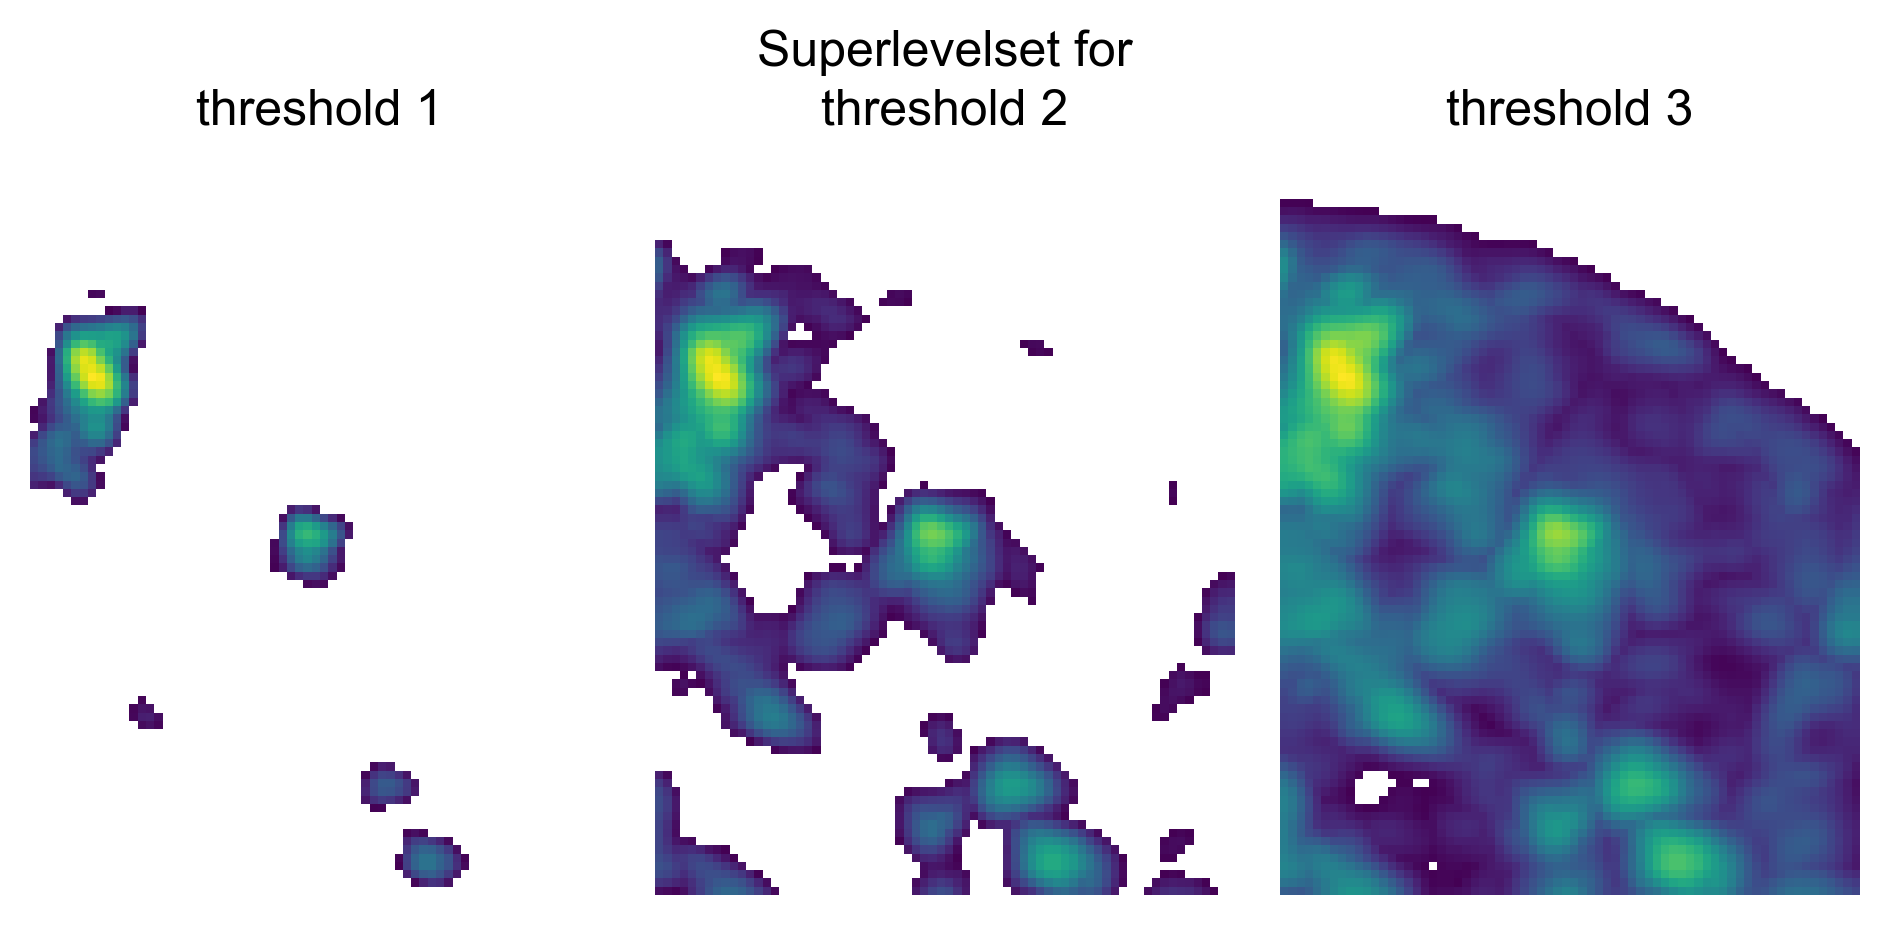

In [468]:
print(np.min(plotimg), np.max(plotimg))
fig, ax = plt.subplots(1,3, dpi=300)

ax[0].imshow(np.ma.masked_array(plotimg, plotimg <= 11000))
ax[1].imshow(np.ma.masked_array(plotimg, plotimg <= 10600))
ax[2].imshow(np.ma.masked_array(plotimg, plotimg <= 10200))

for i in range(3):
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('Superlevelset for', y=0.81, family='Arial')
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_intensityvalues.pdf'), bbox_inches='tight', dpi=300)

In [469]:
labelimages = np.array([label((plotimg > thresh),
                              connectivity=2)
               for thresh in threshvals])
# relabel so that lower label means higher max intensity value
for j in range(np.shape(labelimages)[0]):
    dict_tmp = {region.label: -np.max(plotimg[region.coords[:,0], region.coords[:,1]])
                for region in regionprops(labelimages[j])}
    dict_tmp = {k: v for k, v in sorted(dict_tmp.items(), key=lambda item: item[1])}
    for i, key in enumerate(dict_tmp):
        labelimages[j, labelimages[j] == key] = -(i+1)
labelimages = -labelimages


# now make it so that we have same label for same regions
new_color = np.max(labelimages[0]) + 1
for i in range(1, 3):
    for region in regionprops(labelimages[i]):
        tmp = labelimages[i-1][region.coords[:,0], region.coords[:,1]].astype(np.float32)
        tmpmin = np.min(tmp, where=tmp > 0, initial=np.inf)

        if tmpmin < np.inf:
            labelimages[i, region.coords[:,0], region.coords[:,1]] = tmpmin
        else:
            labelimages[i, region.coords[:,0], region.coords[:,1]] = new_color
            new_color += 1

# now draw persistence

cc = CubicalComplex(top_dimensional_cells=-plotimg)
cc.compute_persistence()

pers0 = cc.persistence_intervals_in_dimension(0)
pers1 = cc.persistence_intervals_in_dimension(1)

# get the segments
segment_labels = {len(pers0)-1: np.unravel_index(cc.cofaces_of_persistence_pairs()[1][0][0], np.shape(plotimg), order='F')}
segment_death = {len(pers0)-1: np.inf}
for i, coface in enumerate(cc.cofaces_of_persistence_pairs()[0][0]):
    segment_labels[i] = np.unravel_index(cc.cofaces_of_persistence_pairs()[0][0][i][0], np.shape(plotimg), order='F')
    segment_death[i] = plotimg[np.unravel_index(cc.cofaces_of_persistence_pairs()[0][0][i][1], np.shape(plotimg), order='F')]

for key in tqdm(segment_labels.keys()):
    indices = segment_labels[key]

    k = 0
    regionlabel = 0
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices]
        k += 1
    segment_labels[key] = [regionlabel, plotimg[indices], list(pers0[key, :])]

segment_labels = {key: segment_labels[key] for key in segment_labels if segment_labels[key][0] != 0}
segment_labels = {k: v for k, v in sorted(segment_labels.items(), key=lambda item: item[0])[::-1]}

# since there might be some segments which already died at this point those are the ones which have
# the same value in the first place.
unq_segment_labels = {}
for valj in np.unique([x[0] for x in segment_labels.values()]):
    tmp_arr = np.array([[keyi, segment_labels[keyi][0], segment_labels[keyi][1], segment_death[keyi]]
                        for keyi in [key for key in segment_labels.keys() if segment_labels[key][0] == valj]])

    # superlevelset
    tmp_idx = np.argsort(tmp_arr[:, 2])[::-1]
    tmp_arr = tmp_arr[tmp_idx, :]

    unq_segment_labels[tmp_arr[0][0].astype(np.int32)] =\
        tmp_arr[0][1].astype(np.int32)

## DO IT FOR THE LOOPS

loop_label = {}
loop_death = {}
for i, coface in enumerate(cc.cofaces_of_persistence_pairs()[0][1]):
    loop_label[i] = np.unravel_index(coface[0], np.shape(plotimg), order='F')
    loop_death[i] = np.unravel_index(coface[1], np.shape(plotimg), order='F')

loop_deaths = {}
loop_labels = {}
for key in tqdm(loop_label.keys()):
    indices = loop_label[key]
    indices_death = loop_death[key]

    # here we need to filter out the circles earlier than the connected components
    # if the loop has already been closed at this time
    if (labelimages[0][indices_death] != 0):
        continue

    k = 0
    regionlabel = 0
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices]
        k += 1
    loop_labels[key] = [regionlabel, k-1, loop_label[key], list(pers1[key])]

    k = 0
    regionlabel = 0
    # we know that for k=0 it's fulfilled
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices_death]
        k += 1
    loop_deaths[key] = [regionlabel, k-1, loop_death[key], list(pers1[key])]

# filter out all which are born later than last image in labelimages
zero_keys = [key for key in loop_labels if loop_labels[key][0] == 0]
loop_labels = {key: loop_labels[key] for key in loop_labels.keys() if key not in zero_keys}
loop_deaths = {key: loop_deaths[key] for key in loop_deaths.keys() if key not in zero_keys}

# filter out all which die earlier than first image in labelimages
idx_in_thresh = [np.where((-pers1[:,0] >= thresh) & (-pers1[:,1] < thresh))[0]
                 for thresh in threshvals]

# # throw away all keys which are not relevant for the thresholds we are showing
# idx_in_thresh_key = [key for keyarr in idx_in_thresh for key in keyarr]
# loop_labels = {key: loop_labels[key] for key in loop_labels.keys() if key in idx_in_thresh_key}
# loop_deaths = {key: loop_deaths[key] for key in loop_deaths.keys() if key in idx_in_thresh_key}

#### CONTOURS

contours = []
for i, thresh in enumerate(threshvals):
    binary = (plotimg >= thresh)
    poss_holes = label(~binary, connectivity=1)

    contour_tmp = []
    for key in idx_in_thresh[i]:
        hole = (poss_holes==poss_holes[loop_deaths[key][2]]).astype(np.int32)
        tmp = measure.find_contours(hole == 1, 0.5)[0]
        contour_tmp.append(tmp.copy())
    contours.append(contour_tmp)


## COLORS
cmap_loops = mpl.colormaps['tab10']
colors_loops = [key for keyarr in idx_in_thresh for key in keyarr]
colors_loops = {key: cmap_loops(i / (len(colors_loops) -1)) for i, key in enumerate(colors_loops)}

# cmap for dimension 0
cmap = mpl.colormaps['tab20']
color = cmap(MinMaxScaler().fit_transform(np.array([unq_segment_labels[key] for key in unq_segment_labels.keys()]).reshape(-1,1)))

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

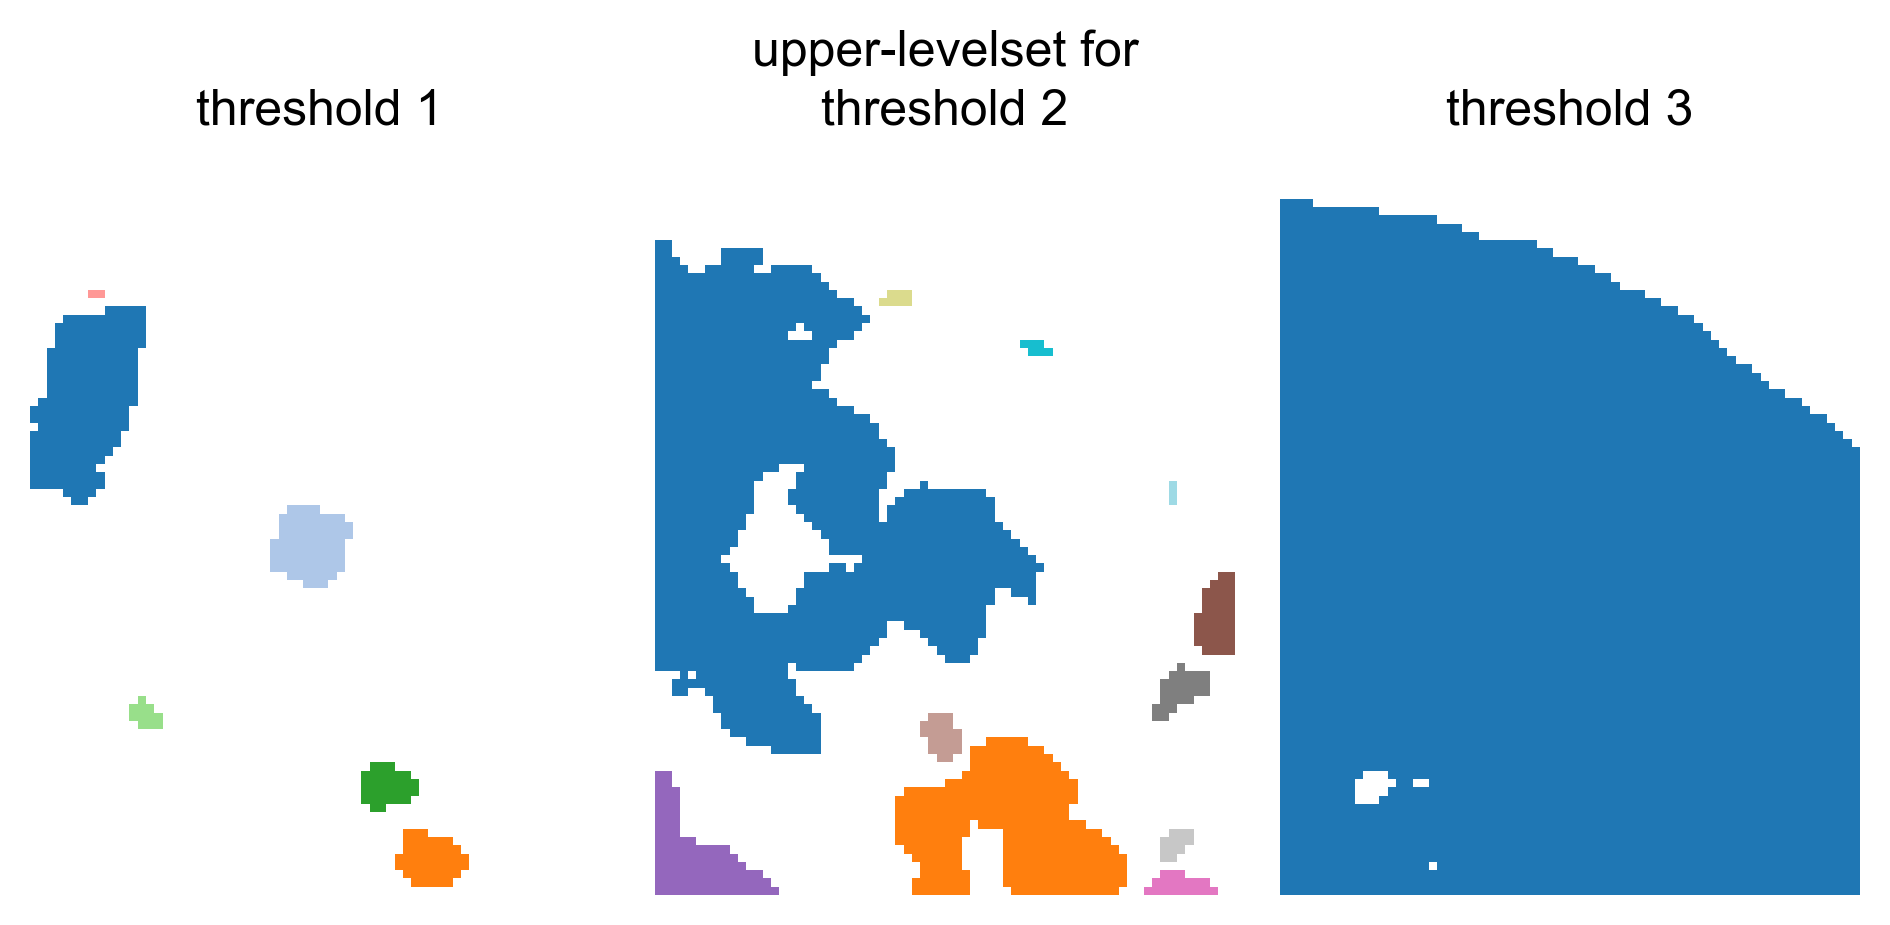

In [470]:
fig, ax = plt.subplots(1,3, dpi=300)
for i, thresh in enumerate(threshvals):
    ax[i].imshow(np.ma.masked_array(labelimages[i], labelimages[i] == 0),
                 cmap=cmap, norm='linear',
                 vmin=1, vmax=np.max(labelimages))
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('upper-levelset for', y=0.81, family='Arial')
fig.tight_layout()
fig.savefig(Path('plots', 'filtration_connectedcomponents.pdf'), bbox_inches='tight', dpi=300)

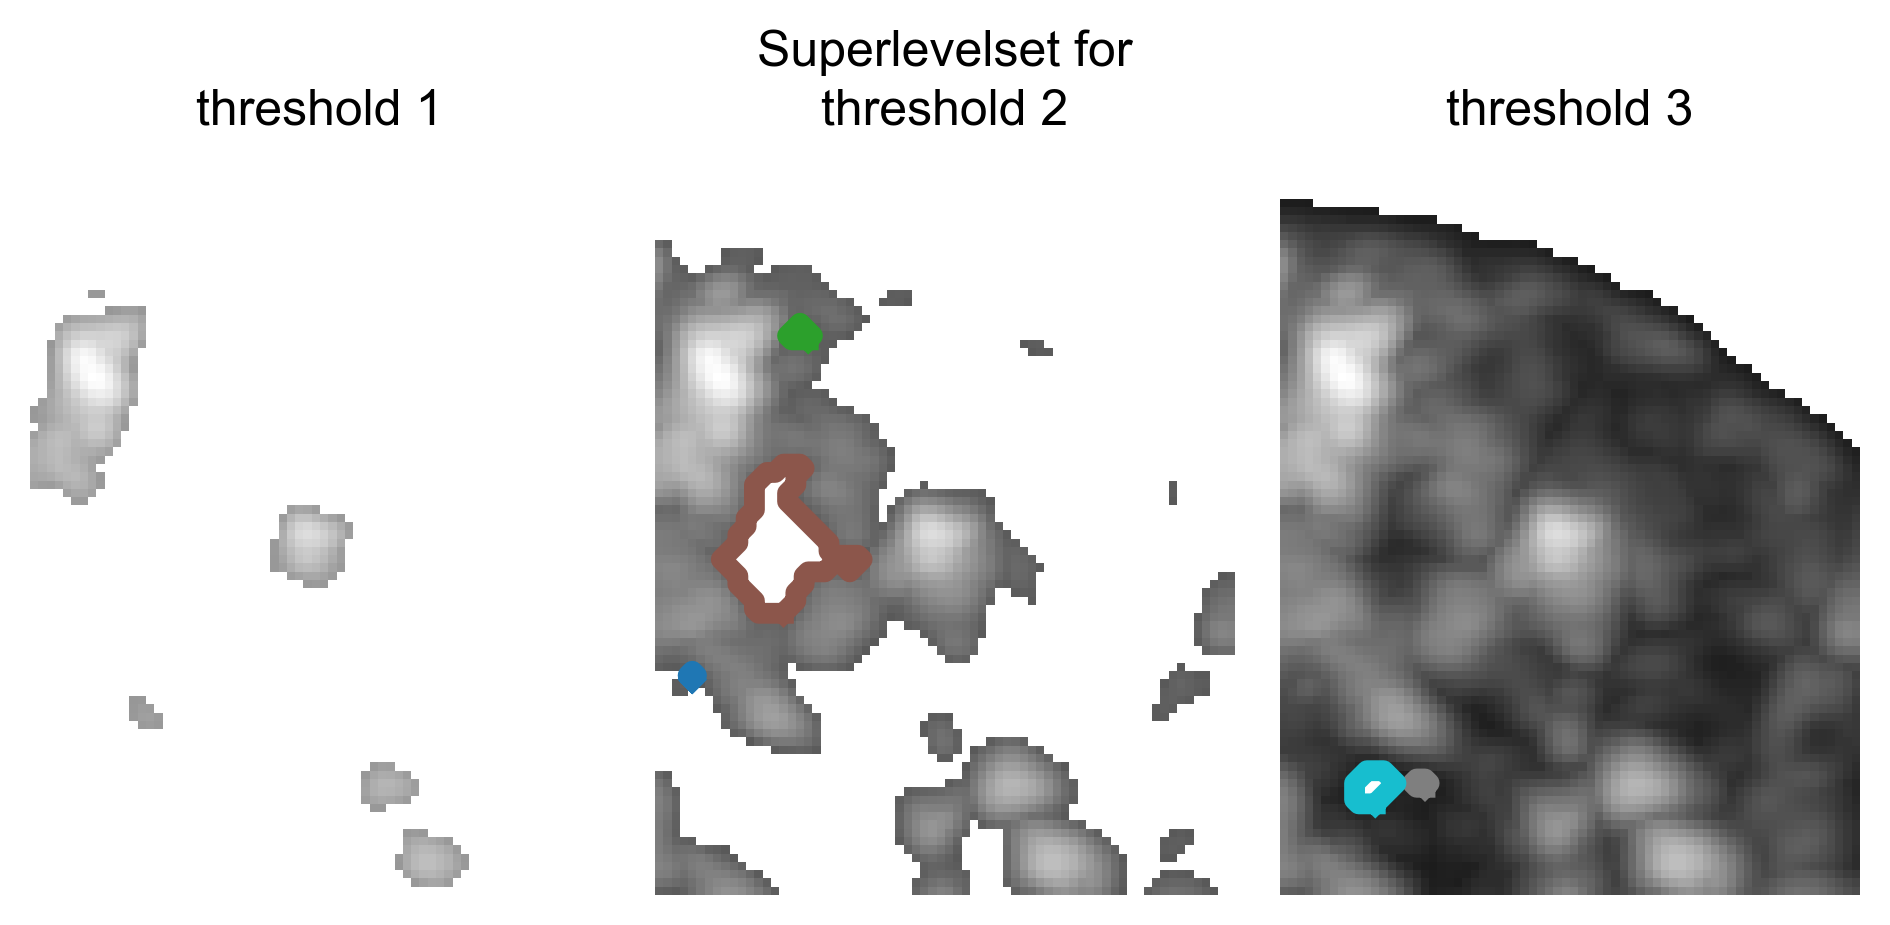

In [471]:
fig, ax = plt.subplots(1,3,dpi=300)

for i in range(3):
    ax[i].imshow(np.ma.masked_array(plotimg, plotimg < threshvals[i]),
                 vmin=np.min(plotimg), vmax=np.max(plotimg),
                 cmap='gray')
    for j, contour in enumerate(contours[i]):
        ax[i].plot(contour[:,1], contour[:,0], 
                   color=colors_loops[idx_in_thresh[i][j]],
                   lw=5)
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('Superlevelset for', y=0.81, family='Arial')
fig.tight_layout()
fig.savefig(Path('plots', 'filtration_loops.pdf'), bbox_inches='tight', dpi=300)

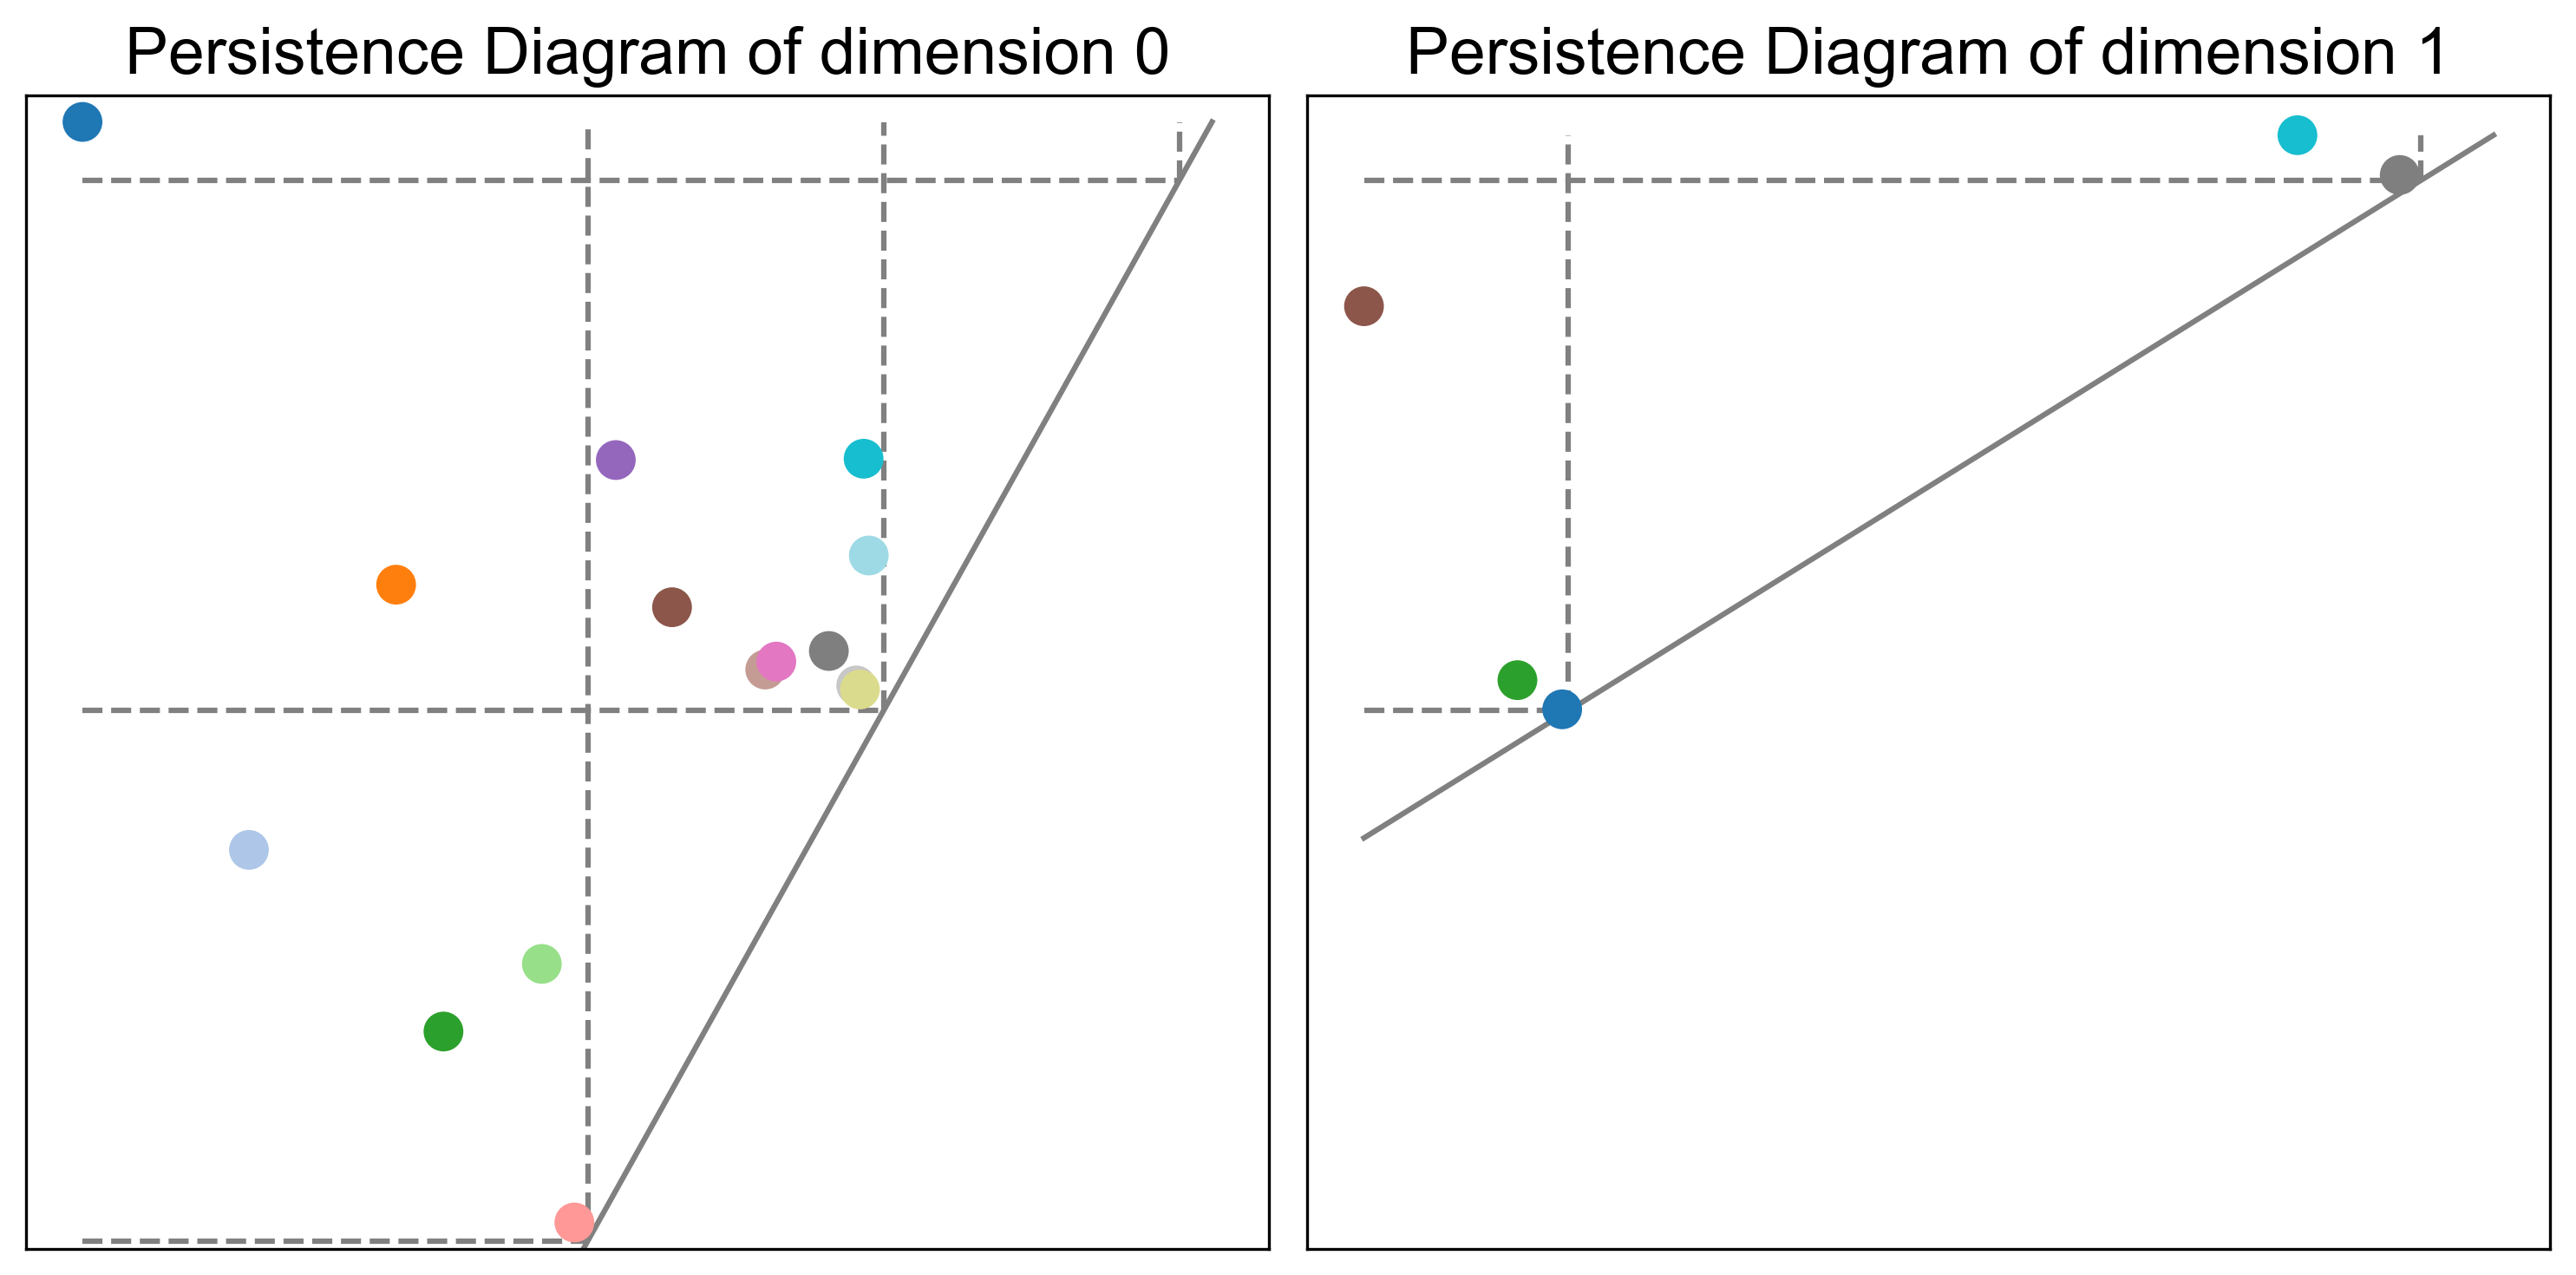

In [472]:
plot_pers0 = pers0[list(unq_segment_labels.keys()), :]
plot_pers1 = []
for key in colors_loops:
    plot_pers1.append(loop_labels[key][-1])
plot_pers1 = np.array(plot_pers1)

plot_pers0[plot_pers0 == np.inf] = max(np.max(plot_pers0[plot_pers0 != np.inf]),
                                       np.max(plot_pers1[plot_pers1 != np.inf])) + 10

### FIGURE
fig, ax = plt.subplots(1,2,dpi=300, figsize=(10,5), sharey=True)

xmin = np.min(plot_pers0[:, 0])
xmax = np.max(plot_pers0[:, 0])
ymin = np.min(plot_pers0[:, 1])
ymax = np.max(plot_pers0[:, 1])

ax[0].plot([xmin, ymax], [xmin, ymax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[0].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[0].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[0].scatter(plot_pers0[:, 0], plot_pers0[:, 1],
              color=color,
              s=10**2)
# ax[0].axis('equal')
# ax[0].axis('off')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_ylim(ymin-10, ymax+10)

xmin = np.min(plot_pers1[:, 0])
xmax = np.max(plot_pers1[:, 0])
ymin = np.min(plot_pers1[:, 1])
ymax = np.max(plot_pers1[:, 1])
ax[1].plot([xmin, ymax], [xmin, ymax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[1].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[1].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[1].scatter(plot_pers1[:, 0], plot_pers1[:, 1],
              color=list(colors_loops.values()),
              s=10**2)
# ax[1].axis('equal')
# ax[1].axis('off')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_ylim(min(np.min(plot_pers0[:, 1]), np.min(plot_pers1[:, 1]))-20,
               max(np.max(plot_pers0[:, 1]), np.max(plot_pers1[:, 1]))+20)

# 
ax[0].set_title('Persistence Diagram of dimension 0', family='Arial', fontsize=18)
ax[1].set_title('Persistence Diagram of dimension 1', family='Arial', fontsize=18)
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_persistencediagram.pdf'), bbox_inches='tight', dpi=300)

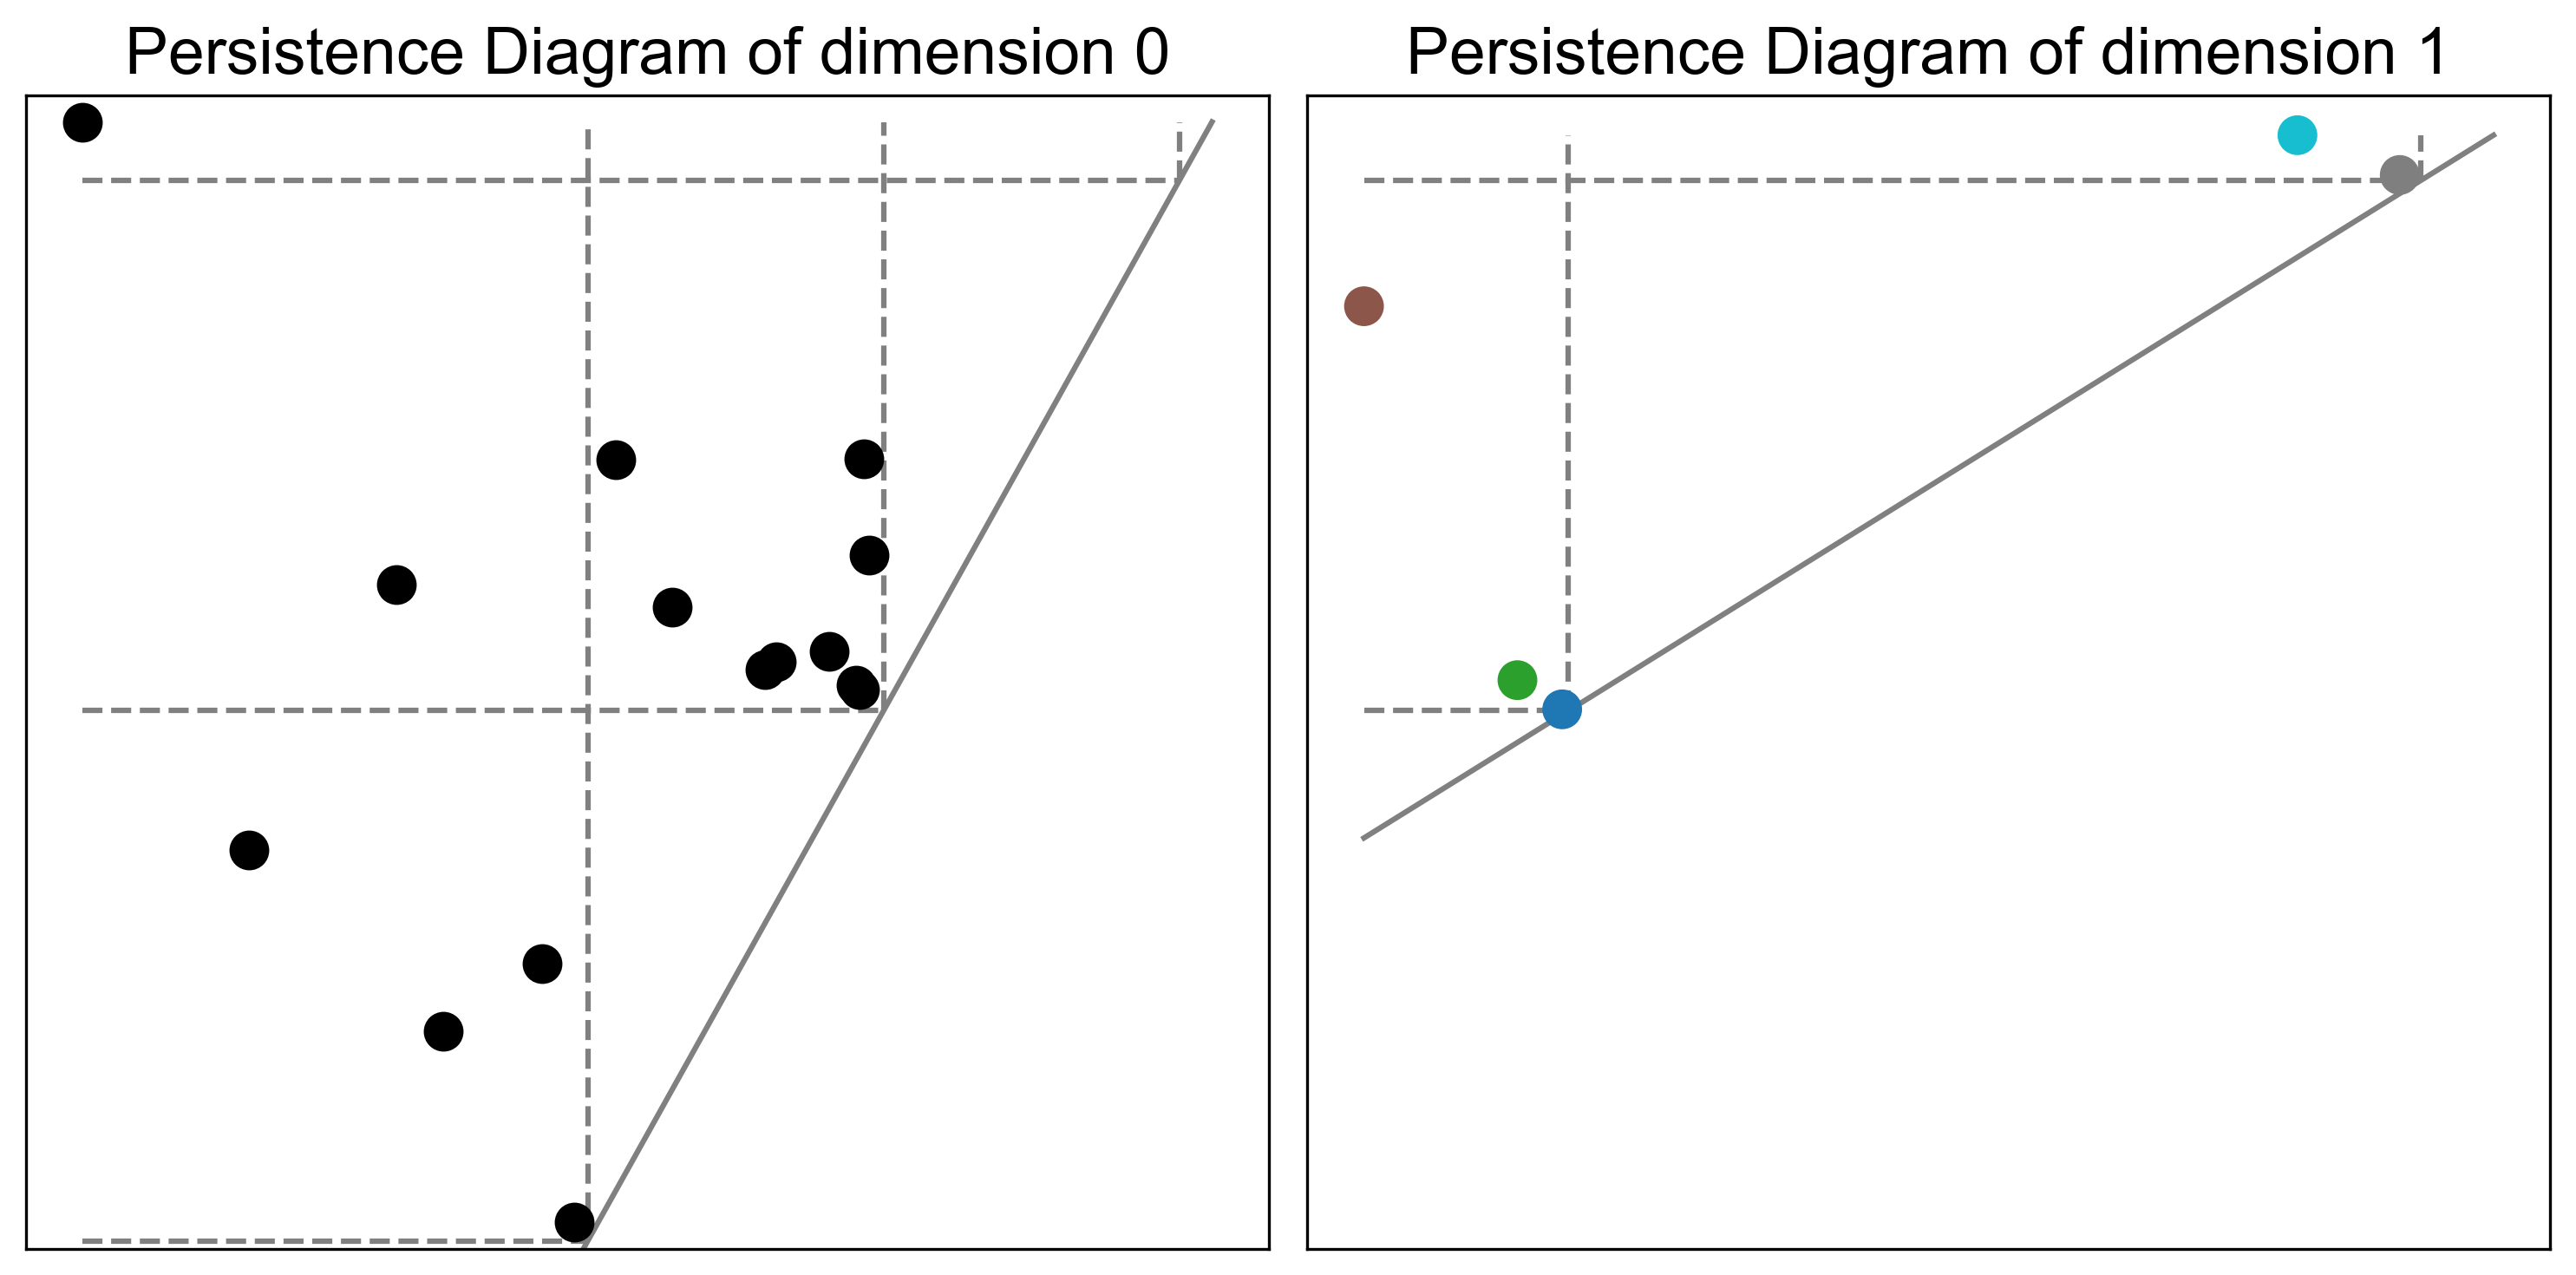

In [473]:
plot_pers0 = pers0[list(unq_segment_labels.keys()), :]
plot_pers1 = []
for key in colors_loops:
    plot_pers1.append(loop_labels[key][-1])
plot_pers1 = np.array(plot_pers1)

plot_pers0[plot_pers0 == np.inf] = max(np.max(plot_pers0[plot_pers0 != np.inf]), np.max(plot_pers1[plot_pers1 != np.inf])) + 10



### FIGURE
fig, ax = plt.subplots(1,2,dpi=300, figsize=(10,5), sharey=True)

xmin = np.min(plot_pers0[:, 0])
xmax = np.max(plot_pers0[:, 0])
ymin = np.min(plot_pers0[:, 1])
ymax = np.max(plot_pers0[:, 1])

ax[0].plot([xmin, ymax], [xmin, ymax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[0].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[0].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[0].scatter(plot_pers0[:, 0], plot_pers0 [:, 1],
              color='black',
              s=10**2)
# ax[0].axis('equal')
# ax[0].axis('off')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_ylim(ymin-10, ymax+10)



xmin = np.min(plot_pers1[:, 0])
xmax = np.max(plot_pers1[:, 0])
ymin = np.min(plot_pers1[:, 1])
ymax = np.max(plot_pers1[:, 1])
ax[1].plot([xmin, ymax], [xmin, ymax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[1].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[1].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[1].scatter(plot_pers1[:, 0], plot_pers1[:, 1],
              color=list(colors_loops.values()),
              s=10**2)
# ax[1].axis('equal')
# ax[1].axis('off')
ax[1].set_yticks([])
ax[1].set_xticks([])
ax[1].set_ylim(min(np.min(plot_pers0[:, 1]), np.min(plot_pers1[:, 1]))-20,
               max(np.max(plot_pers0[:, 1]), np.max(plot_pers1[:, 1]))+20)


# 
ax[0].set_title('Persistence Diagram of dimension 0', family='Arial', fontsize=18)
ax[1].set_title('Persistence Diagram of dimension 1', family='Arial', fontsize=18)
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_persistencediagram_black.pdf'), bbox_inches='tight', dpi=300)

# PIPELINE

In [474]:
style = 'superlevel' # or 'sublevelset'

In [475]:
matrix = np.array([
    [9, 1, 1, 8, 8, 8, 1],
    [1, 1, 10, 7, 2, 6, 8],
    [4, 6, 6, 7, 7, 2, 8],
    [4, 6, 3, 3, 7, 2, 8],
    [6, 6, 3, 3, 10, 8, 6],
    [1, 6, 6, 3, 6, 4, 1],
    [1, 1, 6, 6, 6, 4, 4],
])

In [476]:
def get_sorround_entries(matrix, row, col):
    # row = float, col: float

    rowA = int(np.floor(row))
    rowB = int(np.ceil(row))
    colA = int(np.floor(col))
    colB = int(np.ceil(col))

    return(matrix[max(0, rowA) : min(np.shape(matrix)[0], rowB) + 1,
                  max(0, colA) : min(np.shape(matrix)[0], colB) + 1])

In [477]:
if style == 'superlevel':
    cc = CubicalComplex(top_dimensional_cells=-matrix)
else:
    cc = CubicalComplex(top_dimensional_cells=matrix)
cc.compute_persistence()
pers0 = cc.persistence_intervals_in_dimension(0)
pers1 = cc.persistence_intervals_in_dimension(1)

# if style == 'superlevel':
#     pers0 = -pers0
#     pers1 = -pers1

#     pers0[pers0 == -np.inf] = np.inf

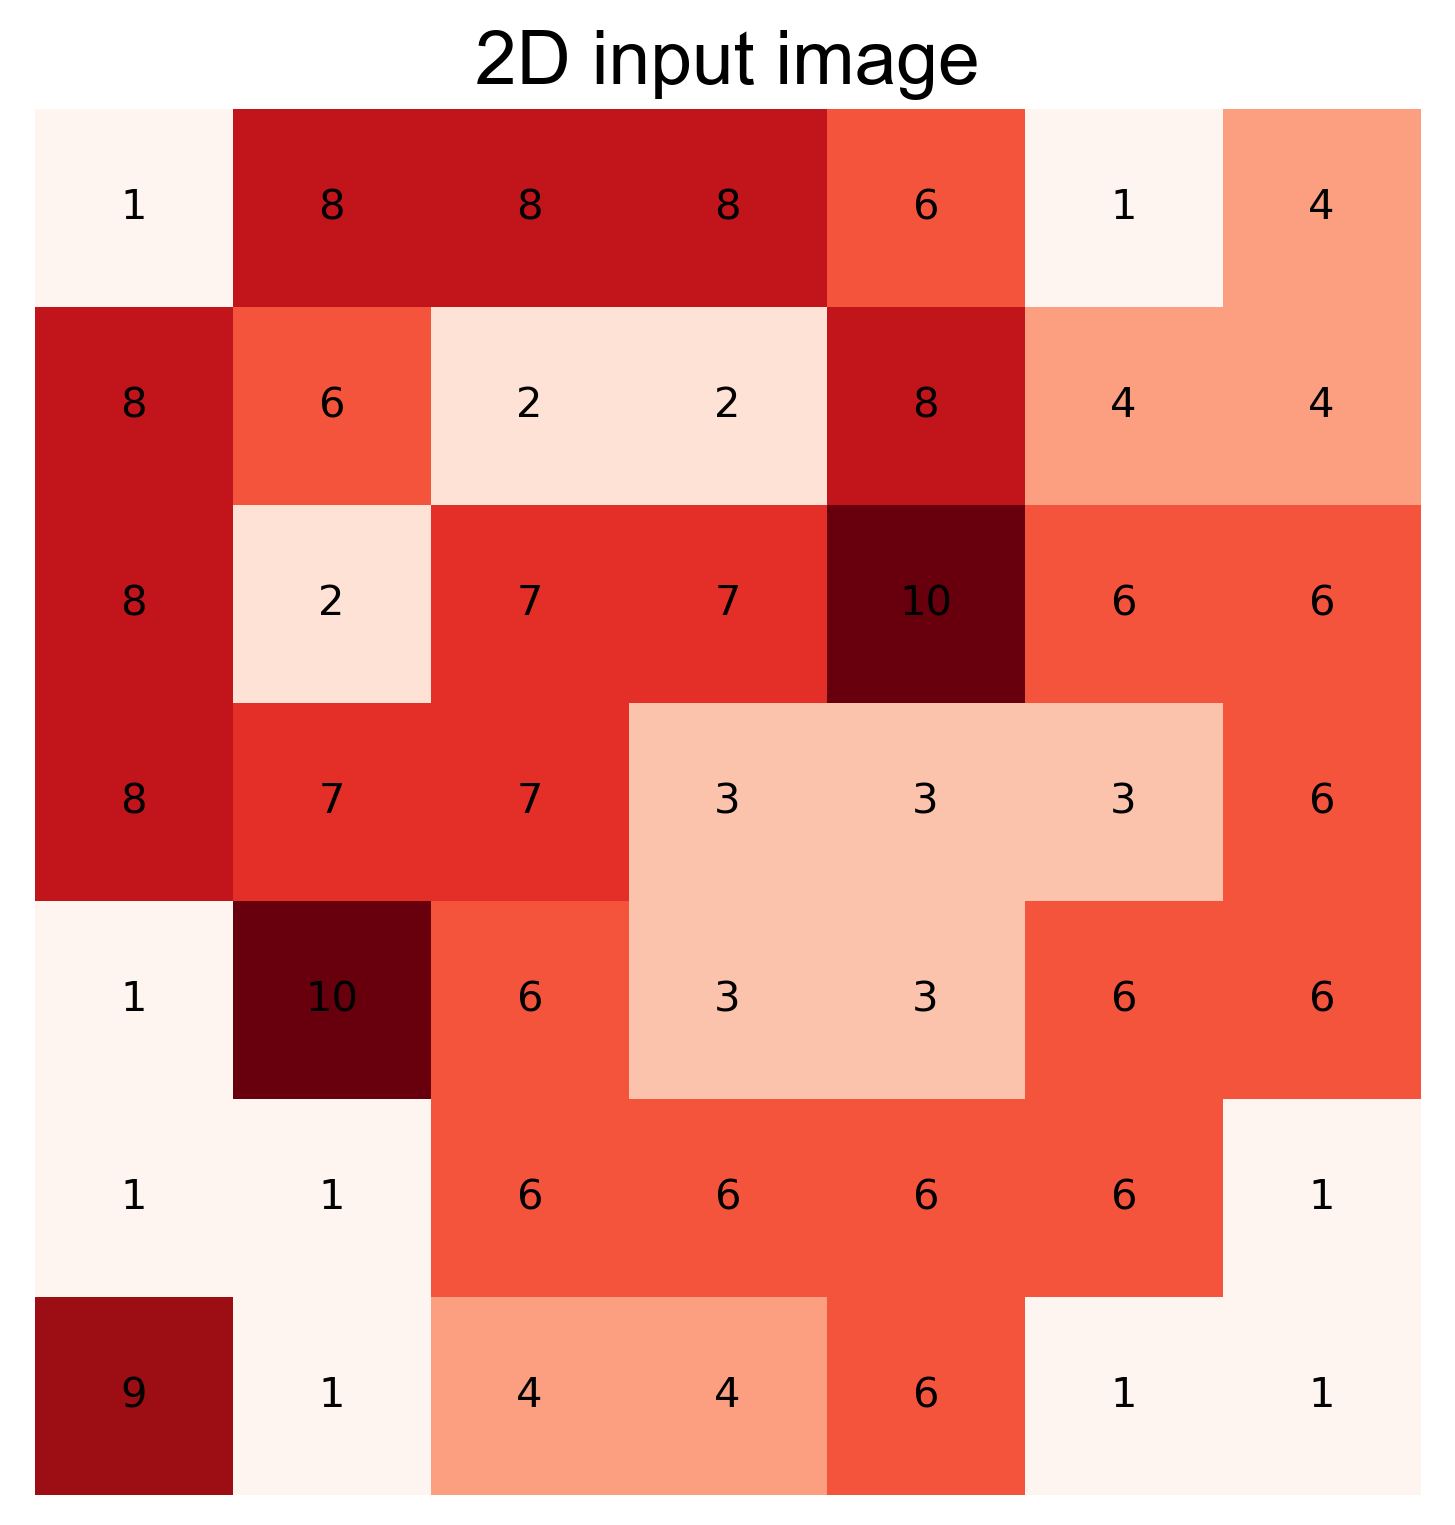

In [478]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax.imshow(matrix.T, cmap='Reds', origin='lower')

for i in range(np.shape(matrix)[0]):
    for j in range(np.shape(matrix)[1]):
        # ax.text(np.shape(matrix)[0] - i -1, np.shape(matrix)[0] - j -1,
        ax.text(i, j,
                f'{matrix[i, j]}',
                ha='center', va='center')

ax.axis('equal')
ax.axis('off')

ax.set_title("2D input image", family='Arial', fontsize=18)
fig.savefig(Path('plots', 'pipeline_image2d.pdf'), dpi=300, bbox_inches='tight')

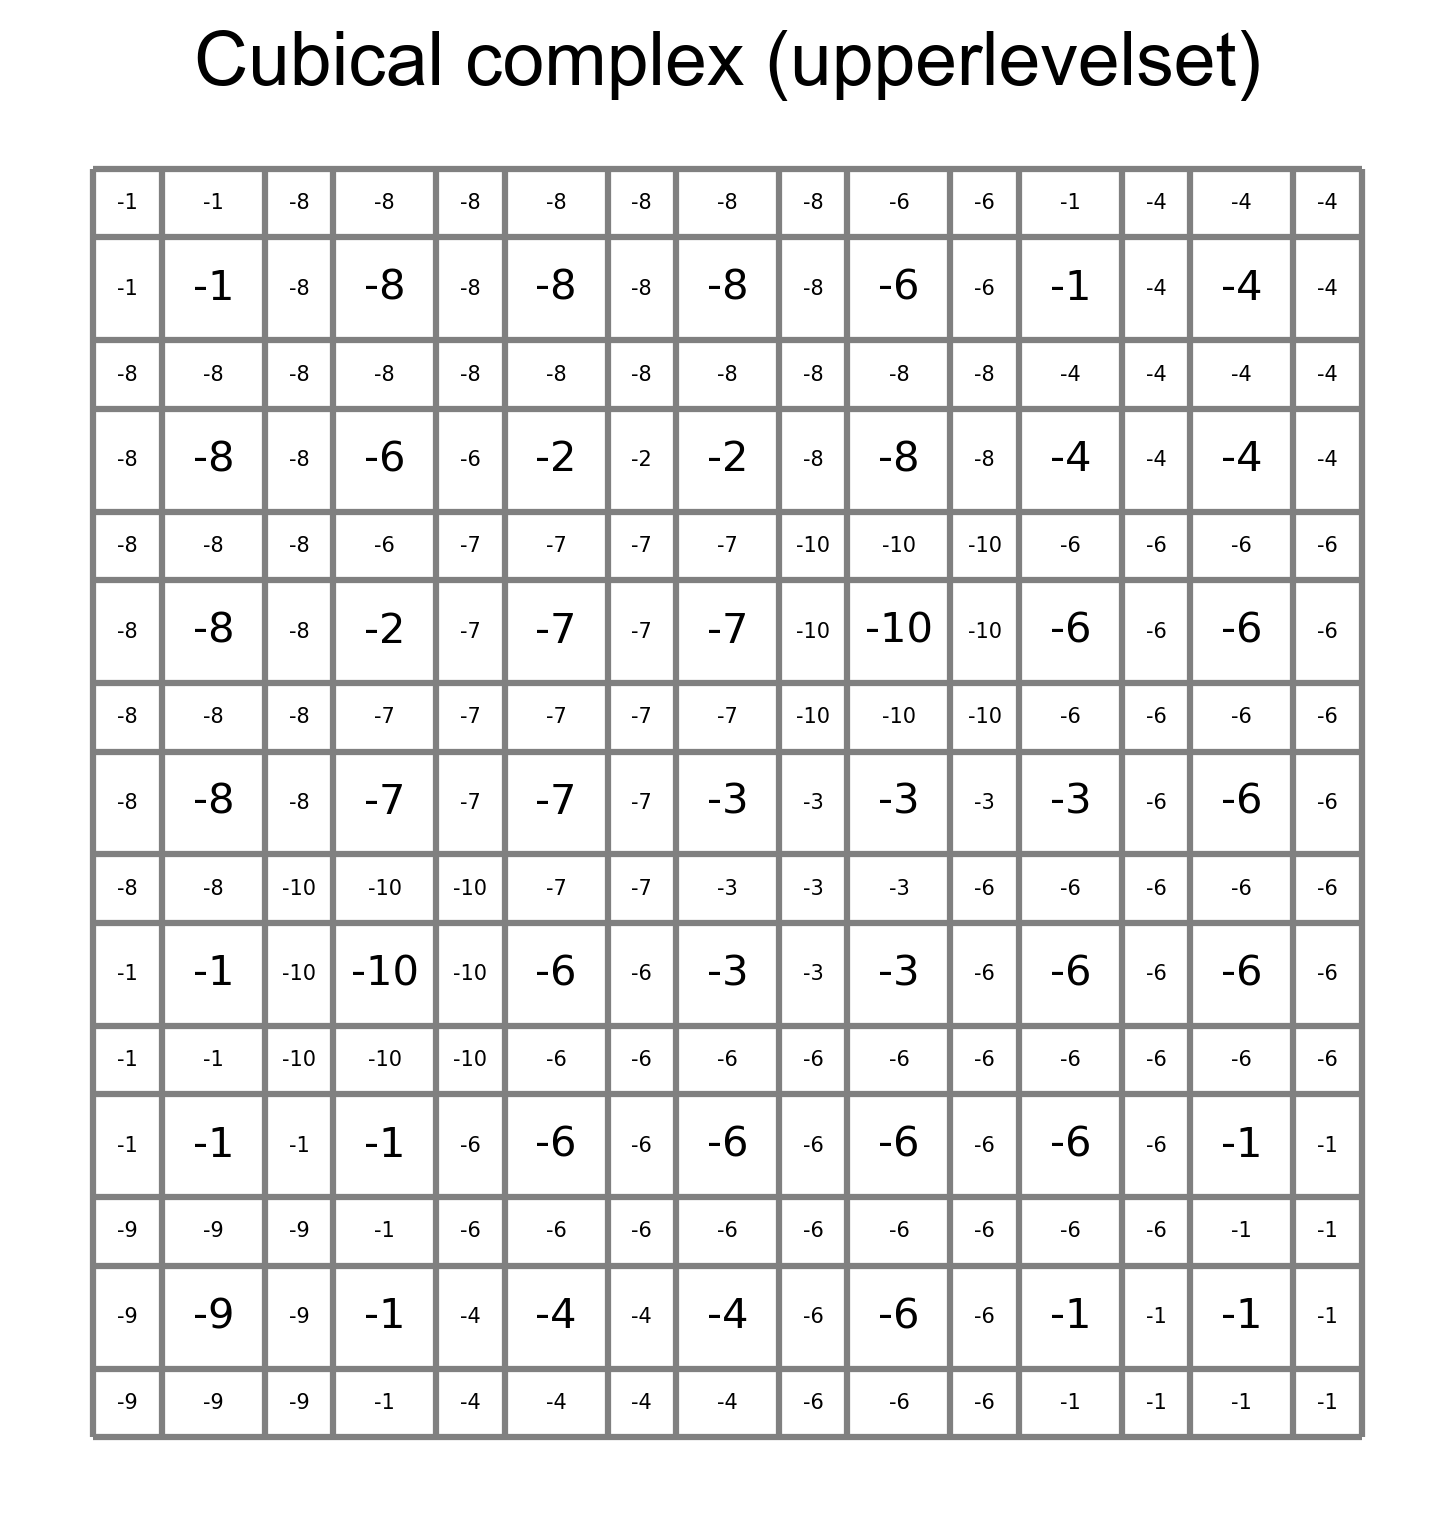

In [479]:
if style == 'superlevel':
    prefix = (-1)
else:
    prefix = 1

# Cubical complex
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

# middle value
for i in range(np.shape(matrix)[0]):
    for j in range(np.shape(matrix)[1]):
        ax.text(i, j, f'{prefix * matrix[i, j]}',
                ha='center', va='center')

# small vertices
for i in range(np.shape(matrix)[0] +1):
    for j in range(np.shape(matrix)[1] + 1):
        entries = get_sorround_entries(matrix, i-0.5, j-0.5)
        if style == 'superlevel':
            value = np.max(entries)
        else:
            value = np.min(entries)
        ax.text(i-0.5, j-0.5, f'{prefix * value}',
                ha='center', va='center', fontsize=5)

# lines
for i in range(np.shape(matrix)[0] +1):
    for j in range(np.shape(matrix)[1] +1):
        entries = get_sorround_entries(matrix, i, j-0.5)
        if entries.size != 0:
            if style == 'superlevel':
                value = np.max(entries)
            else:
                value = np.min(entries)
            ax.text(i, j-0.5, f'{prefix * value}',
                    ha='center', va='center', fontsize=5)

        #
        entries = get_sorround_entries(matrix, i-0.5, j)
        if entries.size != 0:
            if style == 'superlevel':
                value = np.max(entries)
            else:
                value = np.min(entries)
            ax.text(i-0.5, j, f'{prefix * value}',
                    ha='center', va='center', fontsize=5)


# ax.set_xlim(-0.5, np.shape(matrix)[0] + 0.5)
# ax.set_ylim(-0.5, np.shape(matrix)[1] + 0.5)
eps = 0.2

for i in range(np.shape(matrix)[0]+1):
    ax.hlines(i -0.5-eps, -0.5-eps, np.shape(matrix)[0]-0.5+eps,
              color = 'gray')
    ax.hlines(i -0.5+eps, -0.5-eps, np.shape(matrix)[0]-0.5+eps,
              color = 'gray')

for j in range(np.shape(matrix)[1]+1):
    ax.vlines(j -0.5-eps, -0.5-eps, np.shape(matrix)[1]-0.5+eps,
              color = 'gray')
    ax.vlines(j -0.5+eps, -0.5-eps, np.shape(matrix)[1]-0.5+eps,
              color = 'gray')

ax.axis('equal')
ax.axis('off')

if style == 'superlevel':
    ax.set_title("Cubical complex (upperlevelset)", family='Arial', fontsize=18)
else:
    ax.set_title("Cubical complex (sub-levelset)", family='Arial', fontsize=18)
fig.savefig(Path('plots', 'pipeline_cubicalcomplex.pdf'), dpi=300, bbox_inches='tight')

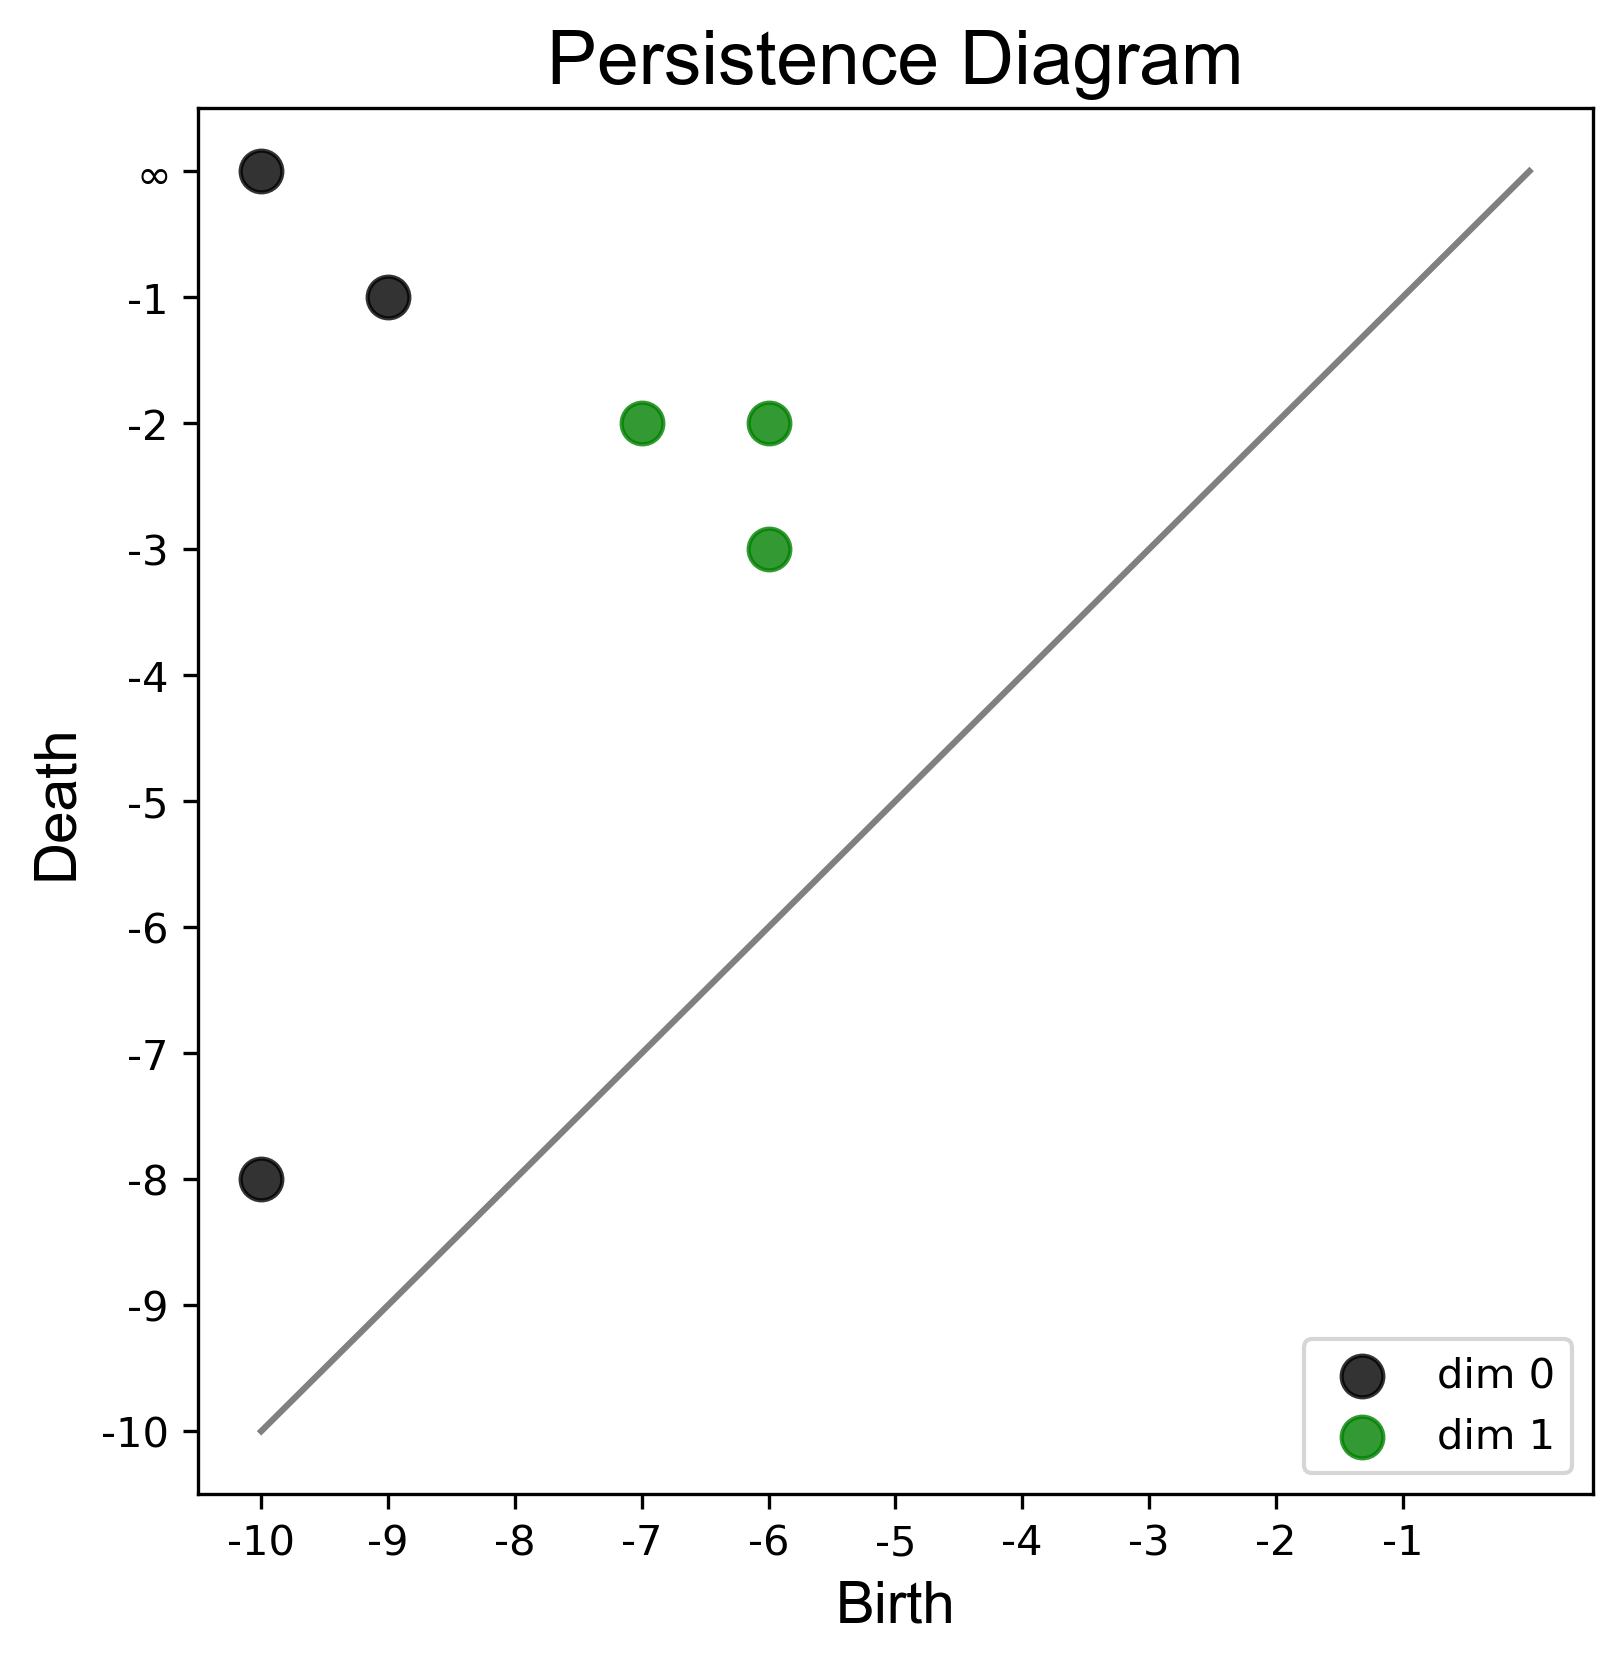

In [480]:
# Persistence Diagram
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)

plot_pers0 = pers0.copy()
textshift = [0.5, 0.5]

if style == 'superlevel':
    inf_value = np.max(-matrix) + 1
else:
    inf_value = np.max(matrix) + 1
plot_pers0[plot_pers0 == np.inf] = inf_value

dim = 0
for pers_tmp, color_tmp, size_tmp in zip([plot_pers0, pers1], ['black', 'green'], [10, 10]):
    plot_pers, plot_count = np.unique(pers_tmp, axis=0, return_counts=True)
    ax.scatter(plot_pers[:,0], plot_pers[:, 1],
               s=size_tmp**2,
               color=color_tmp, alpha=0.8,
               label=f'dim {dim}')

    for idx in np.where(plot_count > 1)[0]:
        ax.text(plot_pers[idx, 0] + textshift[0], plot_pers[idx, 1] - textshift[1],
                f'{plot_count[idx]}', fontsize=10)
    
    dim += 1

vmin = np.min(np.vstack([plot_pers0, pers1]))
vmax = np.max(np.vstack([plot_pers0, pers1]))
ax.plot([vmin, vmax], [vmin, vmax], color='gray', zorder=0.5)

ax.set_yticks([-10,-9, -8, -7, -6, -5, -4, -3, -2, -1, inf_value], [-10,-9, -8, -7, -6, -5, -4, -3, -2, -1, '$\infty$'])
ax.set_xticks([-10,-9, -8, -7, -6, -5, -4, -3, -2, -1], [-10,-9, -8, -7, -6, -5, -4, -3, -2, -1])
ax.set_xlabel('Birth', family='Arial', fontsize=14)
ax.set_ylabel('Death', family='Arial', fontsize=14)

ax.legend()
ax.set_title('Persistence Diagram', family='Arial', fontsize=18)
fig.savefig(Path('plots', 'pipeline_diagram.pdf'), dpi=300, bbox_inches='tight')

In [481]:
from gudhi.representations import BettiCurve, PersistenceImage

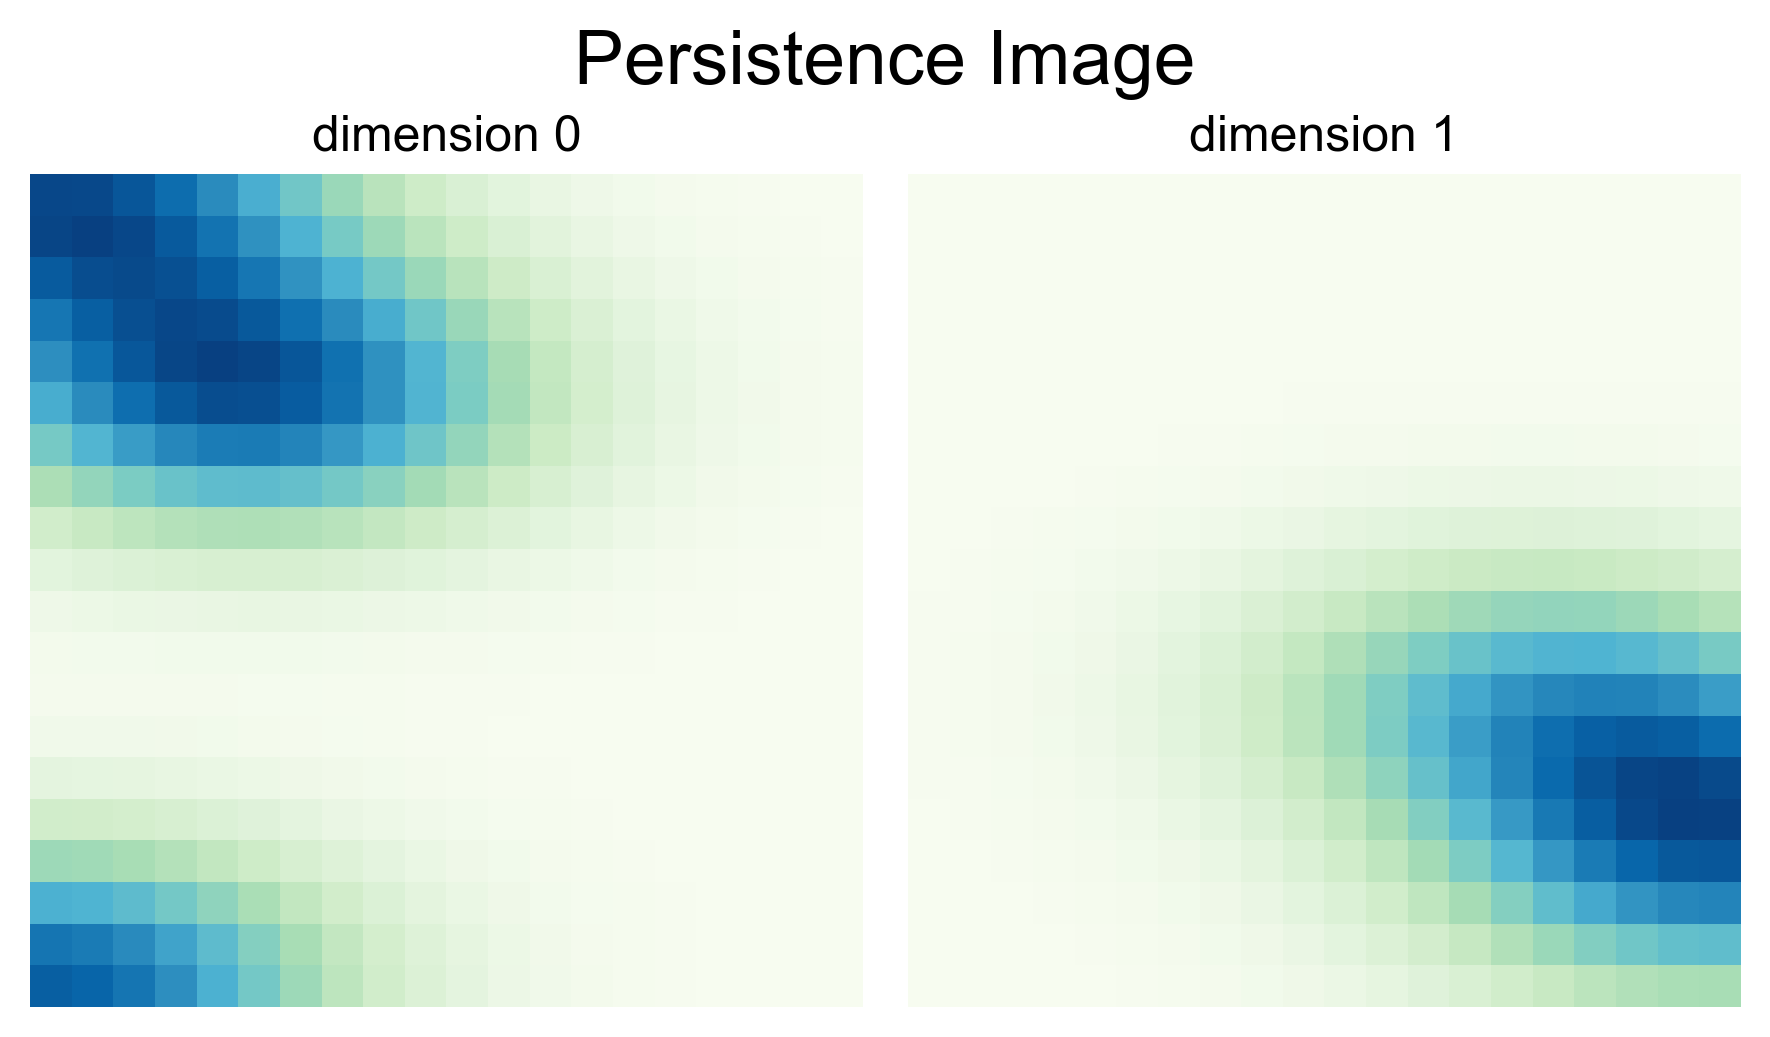

In [482]:
# Persistence Image
fig, ax = plt.subplots(1, 2, figsize=(6, 6), dpi=300)

plot_pers0 = pers0.copy()
if style == 'superlevel':
    inf_value = np.max(-matrix) + 1
else:
    inf_value = np.max(matrix) + 1
plot_pers0[plot_pers0 == np.inf] = inf_value

pimg = PersistenceImage(resolution=[20, 20]).fit_transform([plot_pers0, pers1])
pimg = [x.reshape([20, 20]) for x in pimg]

ax[0].imshow(pimg[0], origin='lower', cmap='GnBu')
ax[1].imshow(pimg[1], origin='lower', cmap='GnBu')

ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('dimension 0', family='Arial')
ax[1].set_title('dimension 1', family='Arial')

fig.suptitle('Persistence Image', family='Arial', fontsize=18, y=0.78)
fig.tight_layout()
fig.savefig(Path('plots', 'pipeline_persimg.pdf'), dpi=300, bbox_inches='tight')

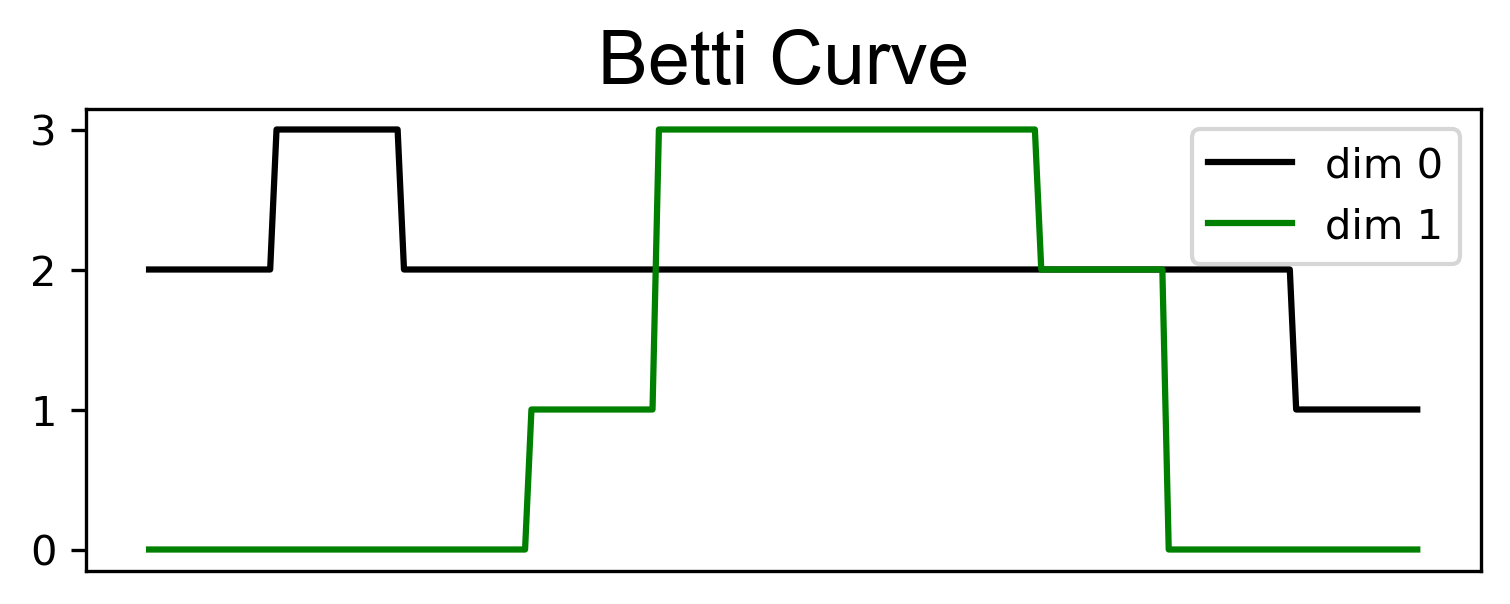

In [483]:
# BettiCurve
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(6,2))

plot_pers0 = pers0.copy()
textshift = [0.5, 0.5]

if style == 'superlevel':
    inf_value = np.max(-matrix) + 1
else:
    inf_value = np.max(matrix) + 1
plot_pers0[plot_pers0 == np.inf] = inf_value

bc_class = BettiCurve(resolution = 200)
bc = bc_class.fit_transform([plot_pers0, pers1])

ax.plot(bc[0], color='black', label='dim 0')
ax.plot(bc[1], color='green', label='dim 1')

# ax.axis('off')
ax.legend()

ax.set_xticks([])
ax.set_yticks(range(4), range(4))
ax.set_title('Betti Curve', family='Arial', fontsize=18)
fig.savefig(Path('plots', 'pipeline_betti.pdf'), dpi=300, bbox_inches='tight')

## a

In [484]:
plotimg = matrix

threshvals = [8, 5, 2]

1 10


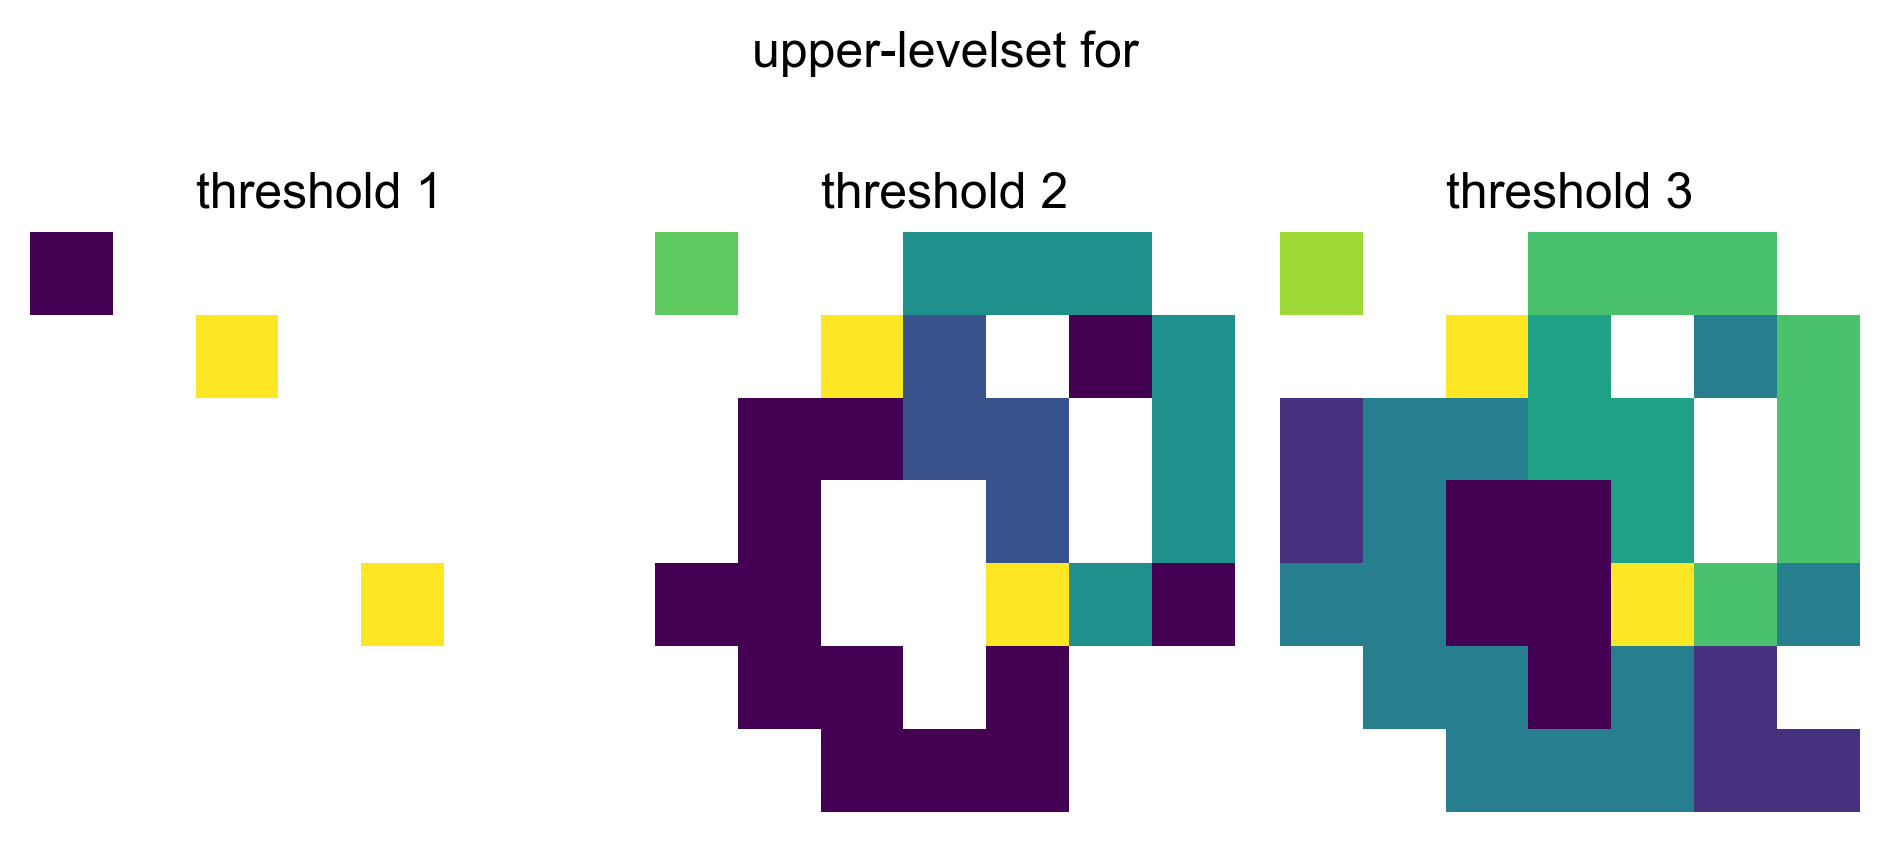

In [485]:
print(np.min(plotimg), np.max(plotimg))
fig, ax = plt.subplots(1,3, dpi=300)

ax[0].imshow(np.ma.masked_array(plotimg, plotimg <= threshvals[0]))
ax[1].imshow(np.ma.masked_array(plotimg, plotimg <= threshvals[1]))
ax[2].imshow(np.ma.masked_array(plotimg, plotimg <= threshvals[2]))

for i in range(3):
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('upper-levelset for', y=0.81, family='Arial')
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_intensityvalues.pdf'), bbox_inches='tight', dpi=300)

In [486]:
labelimages = np.array([label((plotimg > thresh),
                              connectivity=2)
               for thresh in threshvals])
# relabel so that lower label means higher max intensity value
for j in range(np.shape(labelimages)[0]):
    dict_tmp = {region.label: -np.max(plotimg[region.coords[:,0], region.coords[:,1]])
                for region in regionprops(labelimages[j])}
    dict_tmp = {k: v for k, v in sorted(dict_tmp.items(), key=lambda item: item[1])}
    for i, key in enumerate(dict_tmp):
        labelimages[j, labelimages[j] == key] = -(i+1)
labelimages = -labelimages


# now make it so that we have same label for same regions
new_color = np.max(labelimages[0]) + 1
for i in range(1, 3):
    for region in regionprops(labelimages[i]):
        tmp = labelimages[i-1][region.coords[:,0], region.coords[:,1]].astype(np.float32)
        tmpmin = np.min(tmp, where=tmp > 0, initial=np.inf)

        if tmpmin < np.inf:
            labelimages[i, region.coords[:,0], region.coords[:,1]] = tmpmin
        else:
            labelimages[i, region.coords[:,0], region.coords[:,1]] = new_color
            new_color += 1

# now draw persistence

cc = CubicalComplex(top_dimensional_cells=-plotimg)
cc.compute_persistence()

pers0 = cc.persistence_intervals_in_dimension(0)
pers1 = cc.persistence_intervals_in_dimension(1)

# get the segments
segment_labels = {len(pers0)-1: np.unravel_index(cc.cofaces_of_persistence_pairs()[1][0][0], np.shape(plotimg), order='F')}
segment_death = {len(pers0)-1: np.inf}
for i, coface in enumerate(cc.cofaces_of_persistence_pairs()[0][0]):
    segment_labels[i] = np.unravel_index(cc.cofaces_of_persistence_pairs()[0][0][i][0], np.shape(plotimg), order='F')
    segment_death[i] = plotimg[np.unravel_index(cc.cofaces_of_persistence_pairs()[0][0][i][1], np.shape(plotimg), order='F')]

for key in tqdm(segment_labels.keys()):
    indices = segment_labels[key]

    k = 0
    regionlabel = 0
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices]
        k += 1
    segment_labels[key] = [regionlabel, plotimg[indices], list(pers0[key, :])]

segment_labels = {key: segment_labels[key] for key in segment_labels if segment_labels[key][0] != 0}
segment_labels = {k: v for k, v in sorted(segment_labels.items(), key=lambda item: item[0])[::-1]}

# since there might be some segments which already died at this point those are the ones which have
# the same value in the first place.
unq_segment_labels = {}
for valj in np.unique([x[0] for x in segment_labels.values()]):
    tmp_arr = np.array([[keyi, segment_labels[keyi][0], segment_labels[keyi][1], segment_death[keyi]]
                        for keyi in [key for key in segment_labels.keys() if segment_labels[key][0] == valj]])

    # superlevelset
    tmp_idx = np.argsort(tmp_arr[:, 2])[::-1]
    tmp_arr = tmp_arr[tmp_idx, :]

    unq_segment_labels[tmp_arr[0][0].astype(np.int32)] =\
        tmp_arr[0][1].astype(np.int32)

## DO IT FOR THE LOOPS

loop_label = {}
loop_death = {}
for i, coface in enumerate(cc.cofaces_of_persistence_pairs()[0][1]):
    loop_label[i] = np.unravel_index(coface[0], np.shape(plotimg), order='F')
    loop_death[i] = np.unravel_index(coface[1], np.shape(plotimg), order='F')

loop_deaths = {}
loop_labels = {}
for key in tqdm(loop_label.keys()):
    indices = loop_label[key]
    indices_death = loop_death[key]

    # here we need to filter out the circles earlier than the connected components
    # if the loop has already been closed at this time
    if (labelimages[0][indices_death] != 0):
        continue

    k = 0
    regionlabel = 0
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices]
        k += 1
    loop_labels[key] = [regionlabel, k-1, loop_label[key], list(pers1[key])]

    k = 0
    regionlabel = 0
    # we know that for k=0 it's fulfilled
    while k < np.shape(labelimages)[0] and regionlabel == 0:
        regionlabel = labelimages[k][indices_death]
        k += 1
    loop_deaths[key] = [regionlabel, k-1, loop_death[key], list(pers1[key])]

# filter out all which are born later than last image in labelimages
zero_keys = [key for key in loop_labels if loop_labels[key][0] == 0]
loop_labels = {key: loop_labels[key] for key in loop_labels.keys() if key not in zero_keys}
loop_deaths = {key: loop_deaths[key] for key in loop_deaths.keys() if key not in zero_keys}

# filter out all which die earlier than first image in labelimages
idx_in_thresh = [np.where((-pers1[:,0] >= thresh) & (-pers1[:,1] < thresh))[0]
                 for thresh in threshvals]

# # throw away all keys which are not relevant for the thresholds we are showing
# idx_in_thresh_key = [key for keyarr in idx_in_thresh for key in keyarr]
# loop_labels = {key: loop_labels[key] for key in loop_labels.keys() if key in idx_in_thresh_key}
# loop_deaths = {key: loop_deaths[key] for key in loop_deaths.keys() if key in idx_in_thresh_key}

#### CONTOURS

contours = []
for i, thresh in enumerate(threshvals):
    binary = (plotimg >= thresh)
    poss_holes = label(~binary, connectivity=1)

    contour_tmp = []
    for key in idx_in_thresh[i]:
        hole = (poss_holes==poss_holes[loop_deaths[key][2]]).astype(np.int32)
        tmp = measure.find_contours(hole == 1, 0.5)[0]
        contour_tmp.append(tmp.copy())
    contours.append(contour_tmp)


## COLORS
cmap_loops = mpl.colormaps['tab10']
colors_loops = [key for keyarr in idx_in_thresh for key in keyarr]
colors_loops = {key: cmap_loops(i / (len(colors_loops) -1)) for i, key in enumerate(colors_loops)}

# cmap for dimension 0
cmap = mpl.colormaps['tab20']
color = cmap(MinMaxScaler().fit_transform(np.array([unq_segment_labels[key] for key in unq_segment_labels.keys()]).reshape(-1,1)))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

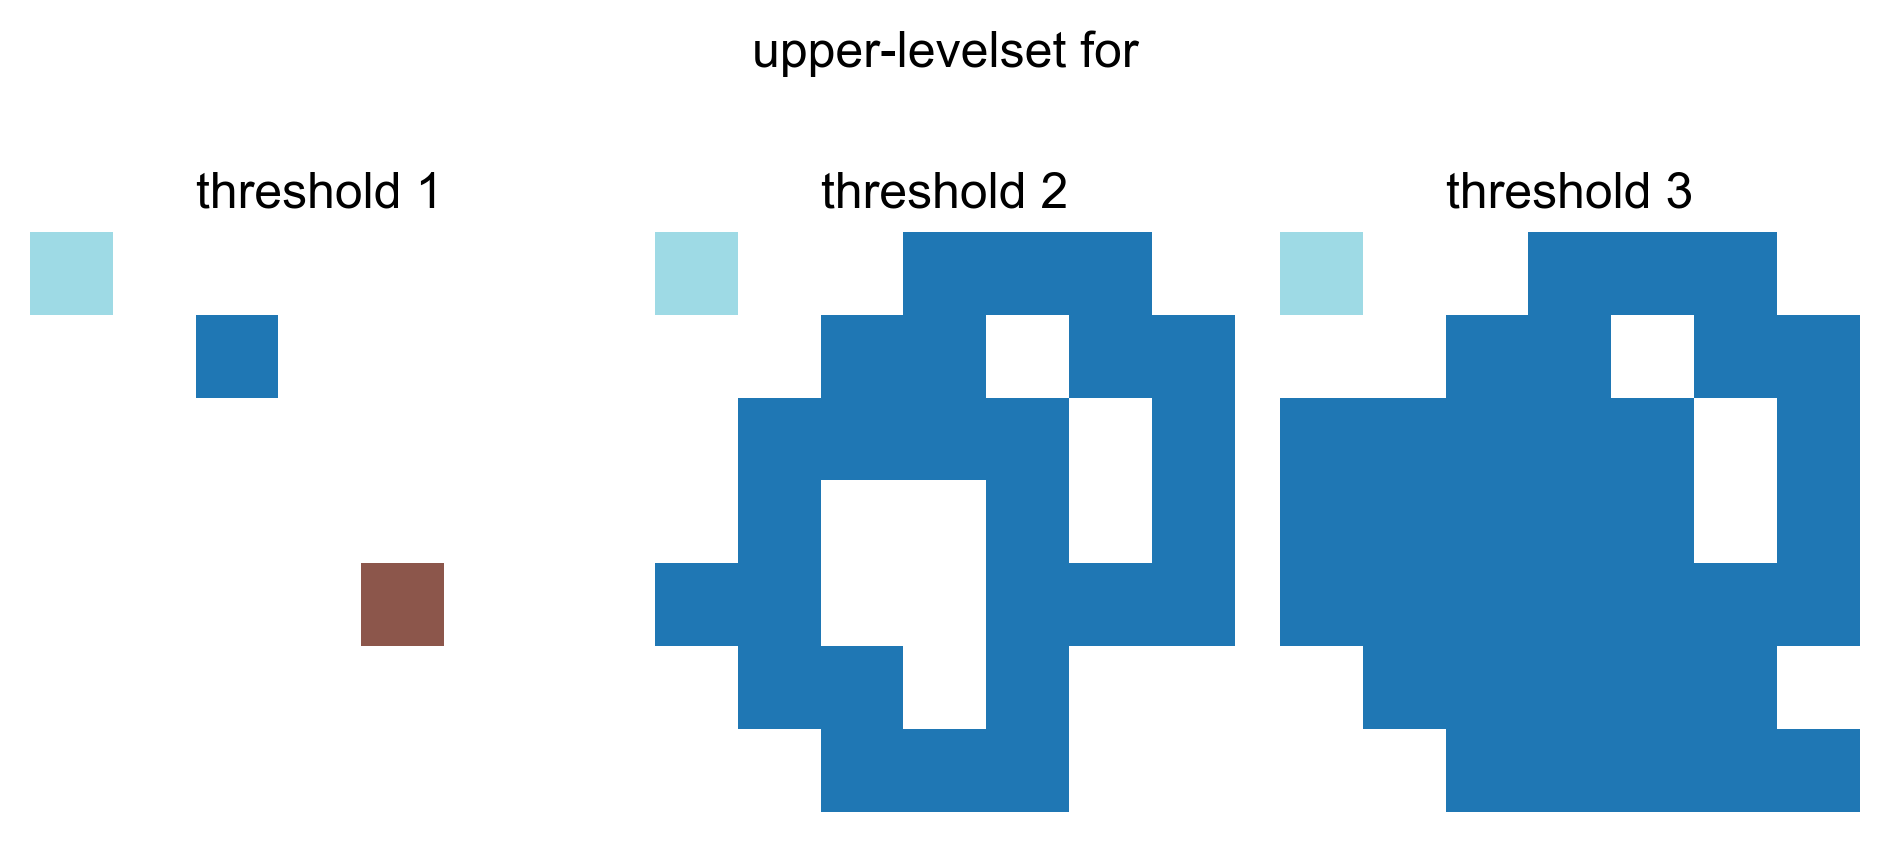

In [487]:
fig, ax = plt.subplots(1,3, dpi=300)
for i, thresh in enumerate(threshvals):
    ax[i].imshow(np.ma.masked_array(labelimages[i], labelimages[i] == 0),
                 cmap=cmap, norm='linear',
                 vmin=1, vmax=np.max(labelimages))
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('upper-levelset for', y=0.81, family='Arial')
fig.tight_layout()
fig.savefig(Path('plots', 'filtration_connectedcomponents.pdf'), bbox_inches='tight', dpi=300)

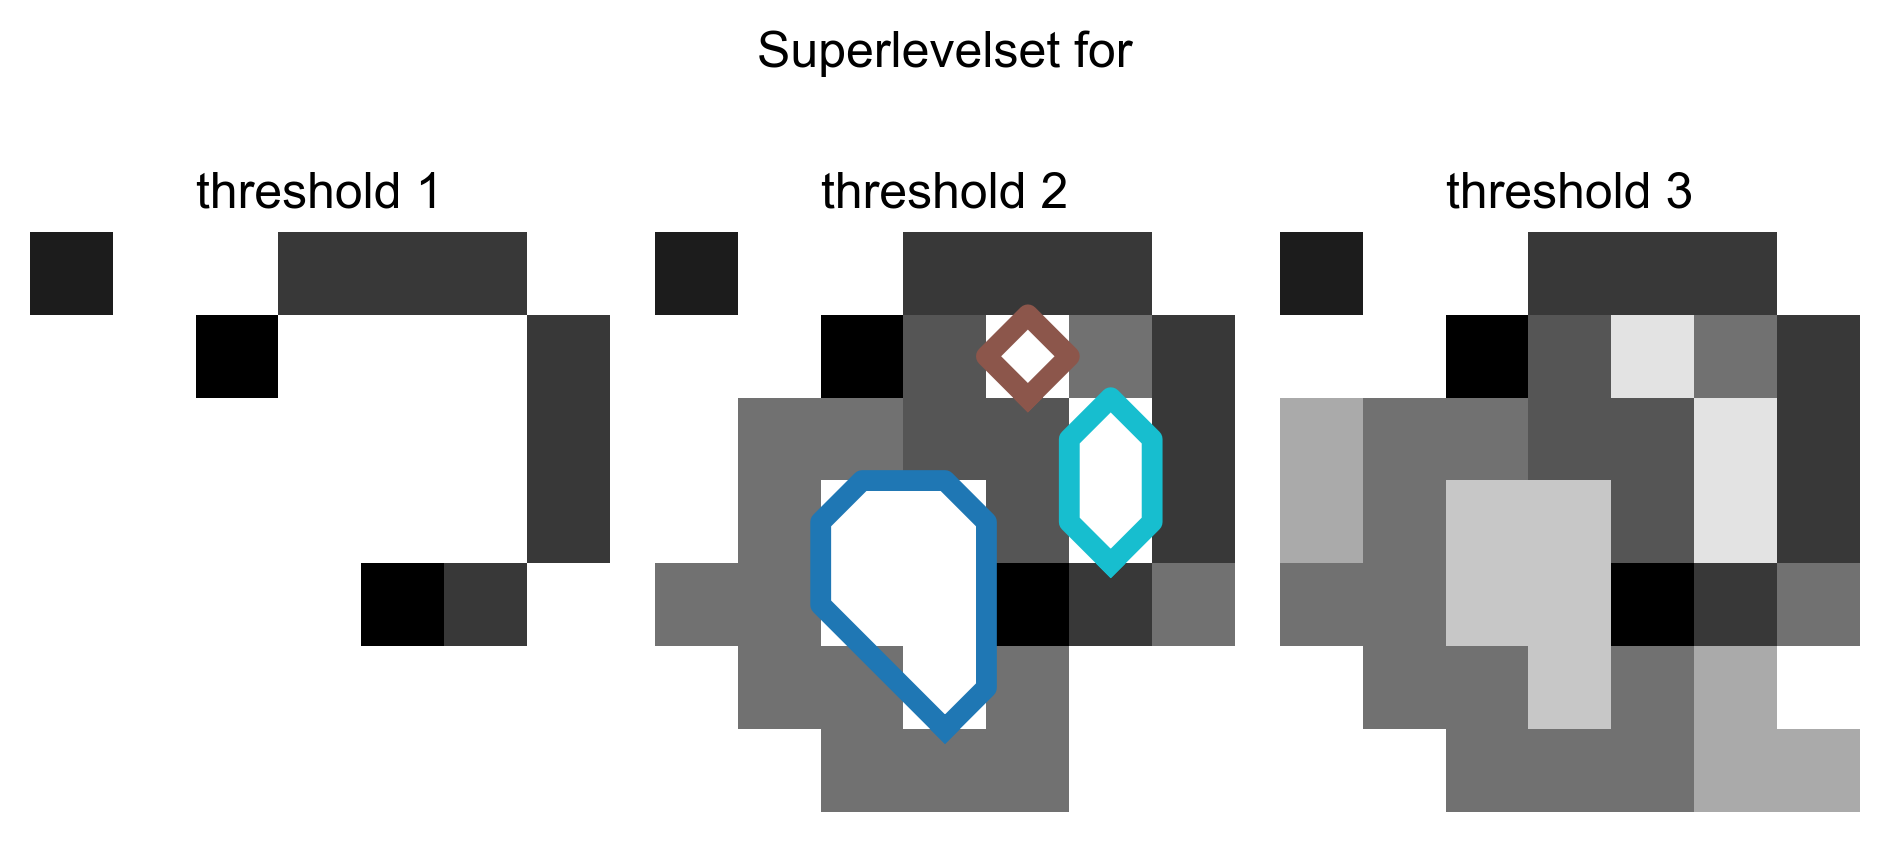

In [488]:
fig, ax = plt.subplots(1,3,dpi=300)

for i in range(3):
    ax[i].imshow(np.ma.masked_array(-plotimg, plotimg < threshvals[i]),
                 vmin=np.min(-plotimg), vmax=np.max(-plotimg),
                 cmap='gray')
    for j, contour in enumerate(contours[i]):
        ax[i].plot(contour[:,1], contour[:,0], 
                   color=colors_loops[idx_in_thresh[i][j]],
                   lw=5)
    ax[i].axis('off')

ax[0].set_title('threshold 1', family='Arial')
ax[1].set_title('threshold 2', family='Arial')
ax[2].set_title('threshold 3', family='Arial')
fig.suptitle('Superlevelset for', y=0.81, family='Arial')
fig.tight_layout()
fig.savefig(Path('plots', 'filtration_loops.pdf'), bbox_inches='tight', dpi=300)

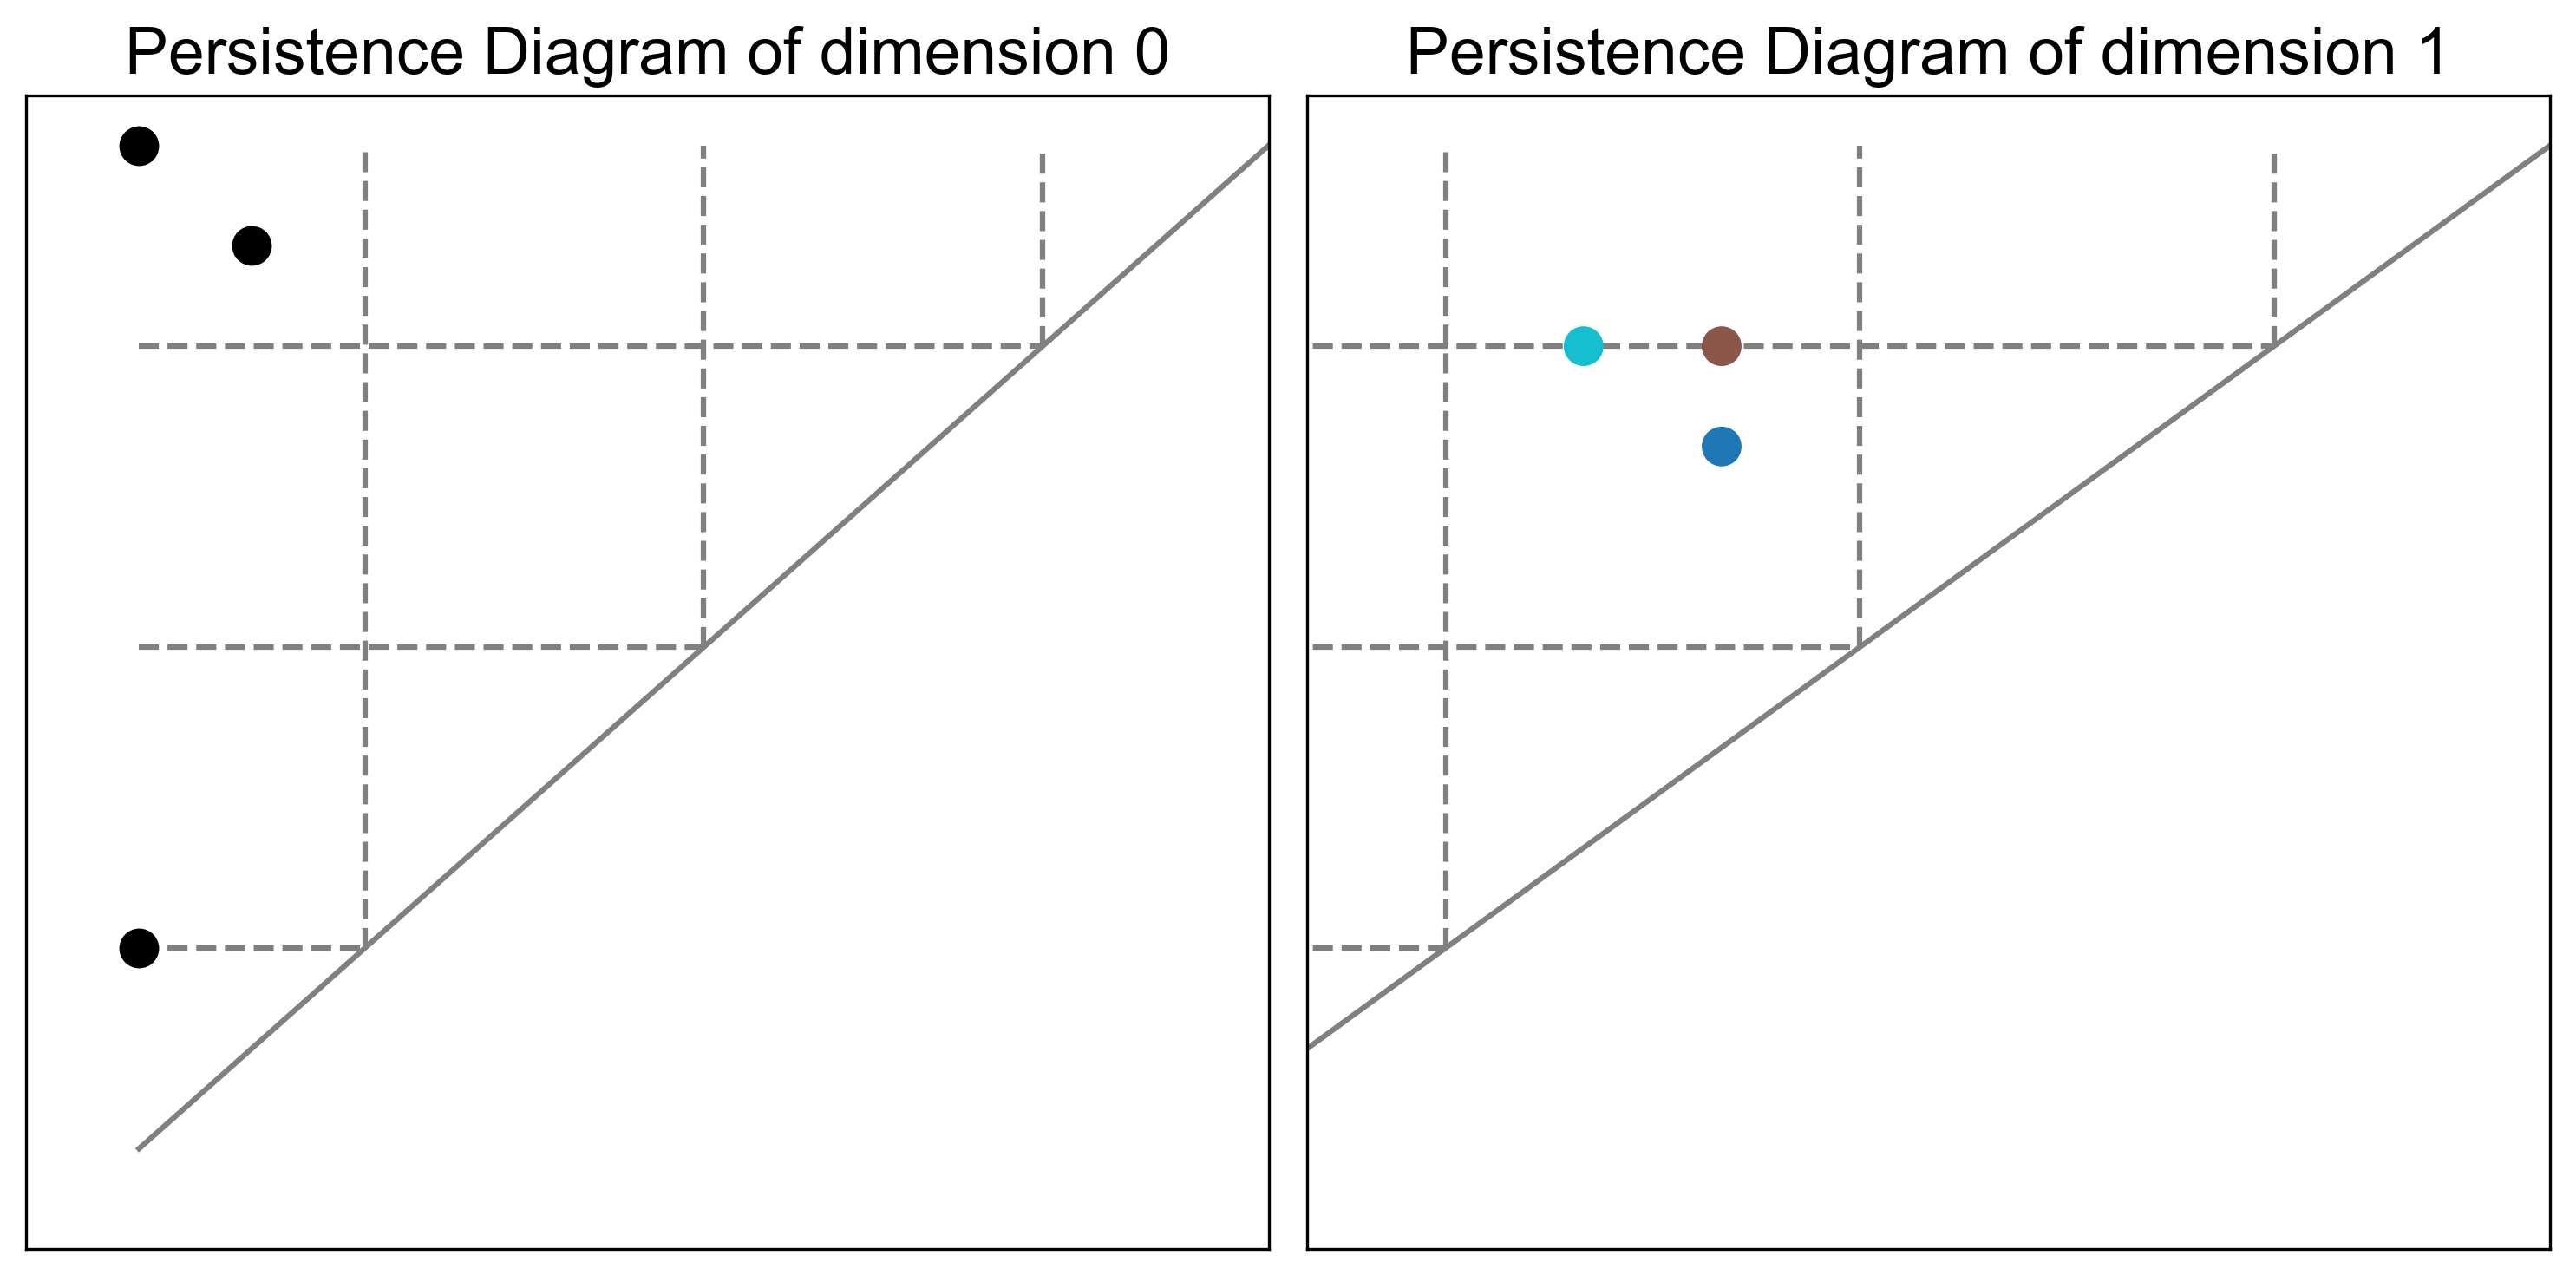

In [489]:
plot_pers0 = pers0[list(unq_segment_labels.keys()), :]
plot_pers1 = []
for key in colors_loops:
    plot_pers1.append(loop_labels[key][-1])
plot_pers1 = np.array(plot_pers1)

plot_pers0[plot_pers0 == np.inf] = max(np.max(plot_pers0[plot_pers0 != np.inf]), np.max(plot_pers1[plot_pers1 != np.inf])) + 1


### FIGURE
fig, ax = plt.subplots(1,2,dpi=300, figsize=(10,5), sharey=True)

xmin = np.min(plot_pers0[:, 0])
xmax = np.max(plot_pers0[:, 0])
ymin = np.min(plot_pers0[:, 1])
ymax = np.max(plot_pers0[:, 1])

vmin = xmin.copy()
vmax = ymax.copy()

# ax[0].plot([xmin, ymax], [xmin, ymax],
#            color='gray', zorder=0.5)
ax[0].plot([vmin, vmax], [vmin, vmax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[0].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[0].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[0].scatter(plot_pers0[:, 0], plot_pers0 [:, 1],
              color='black',
              s=10**2)
# ax[0].axis('equal')
# ax[0].axis('off')
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_ylim(ymin, ymax)


# ax[1].plot([xmin, ymax], [xmin, ymax],
#            color='gray', zorder=0.5)
ax[1].plot([vmin, vmax], [vmin, vmax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[1].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[1].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[1].scatter(plot_pers1[:, 0], plot_pers1[:, 1],
              color=list(colors_loops.values()),
              s=10**2)
# ax[1].axis('equal')
# ax[1].axis('off')
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[1].set_ylim(-11, 0.5)
ax[0].set_xlim(-11, 0)
ax[1].set_xlim(-9, 0)

# 
ax[0].set_title('Persistence Diagram of dimension 0', family='Arial', fontsize=18)
ax[1].set_title('Persistence Diagram of dimension 1', family='Arial', fontsize=18)
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_persistencediagram_colored.pdf'), bbox_inches='tight', dpi=300)

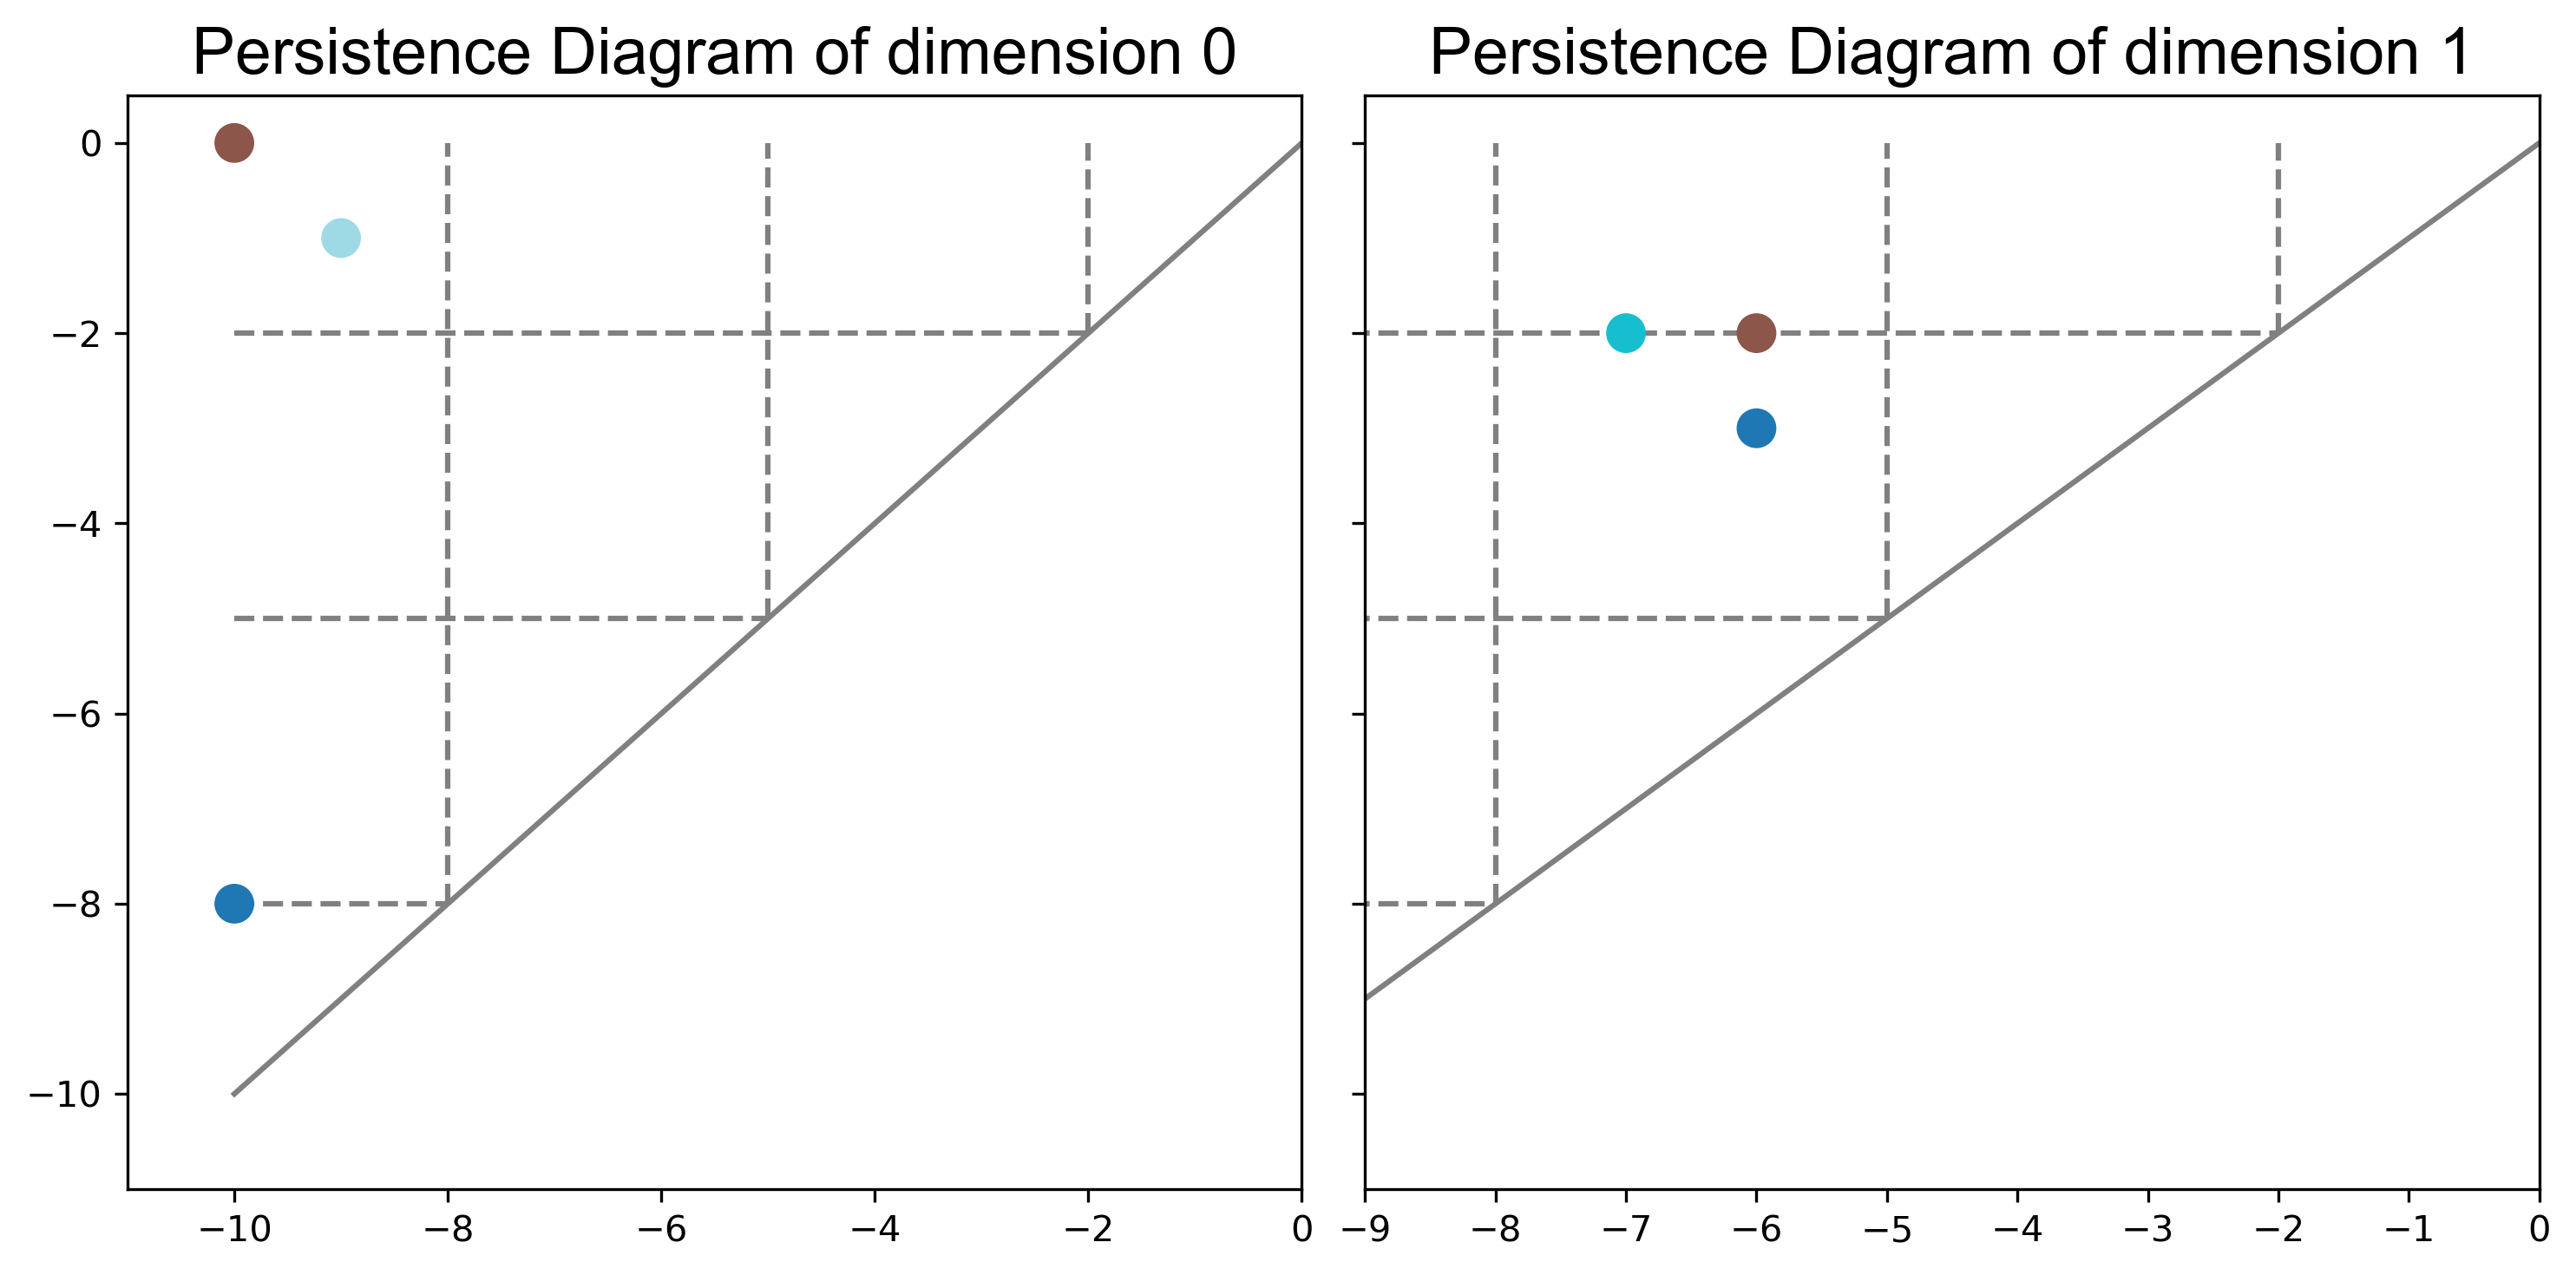

In [490]:
plot_pers0 = pers0[list(unq_segment_labels.keys()), :]
plot_pers1 = []
for key in colors_loops:
    plot_pers1.append(loop_labels[key][-1])
plot_pers1 = np.array(plot_pers1)

plot_pers0[plot_pers0 == np.inf] = max(np.max(plot_pers0[plot_pers0 != np.inf]),
                                       np.max(plot_pers1[plot_pers1 != np.inf])) + 1

### FIGURE
fig, ax = plt.subplots(1, 2, dpi=300, figsize=(10,5), sharey=True)

xmin = np.min(plot_pers0[:, 0])
xmax = np.max(plot_pers0[:, 0])
ymin = np.min(plot_pers0[:, 1])
ymax = np.max(plot_pers0[:, 1])

vmin = xmin.copy()
vmax = ymax.copy()

# ax[0].plot([xmin, ymax], [xmin, ymax],
#            color='gray', zorder=0.5)
ax[0].plot([vmin, vmax], [vmin, vmax],
            color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[0].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[0].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[0].scatter(plot_pers0[:, 0], plot_pers0[:, 1],
              color=color,
              s=10**2)
# ax[0].axis('equal')
# ax[0].axis('off')
# ax[0].set_yticks([])
# ax[0].set_xticks([])
# ax[0].set_ylim(ymin, ymax)

# ax[1].plot([xmin, ymax], [xmin, ymax],
#            color='gray', zorder=0.5)
ax[1].plot([vmin, vmax], [vmin, vmax],
           color='gray', zorder=0.5)
for thresh in threshvals:
    if -thresh <= max(xmax, ymax) and -thresh >= min(xmin, ymin):
        ax[1].hlines(-thresh, xmin, -thresh, ls='dashed', color='gray', zorder=0.5)
        ax[1].vlines(-thresh, -thresh, ymax, ls='dashed', color='gray', zorder=0.5)

ax[1].scatter(plot_pers1[:, 0], plot_pers1[:, 1],
              color=list(colors_loops.values()),
              s=10**2)
# ax[1].axis('equal')
# ax[1].axis('off')
# ax[1].set_yticks([])

ax[1].set_ylim(-11, 0.5)
ax[0].set_xlim(-11, 0)
ax[1].set_xlim(-9, 0)

ax[0].set_title('Persistence Diagram of dimension 0', family='Arial', fontsize=18)
ax[1].set_title('Persistence Diagram of dimension 1', family='Arial', fontsize=18)
fig.tight_layout()

fig.savefig(Path('plots', 'filtration_persistencediagram.pdf'), bbox_inches='tight', dpi=300)